### Rede Neural - MLP (Multi-layer Perceptron)

In [2]:
# Importando os módulos necessários para o processamento dos dados
import numpy   as np
import pandas  as pd

# Módulos necessários para visualização dos dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importando os módulos auxiliares

from sklearn.model_selection import train_test_split # Divisão de conjunto de treinamento e teste
from sklearn.model_selection import cross_validate # Validação cruzada do modelo
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV # Busca pelos melhores hiperparâmetros
from sklearn.externals import joblib # Necessário para salvar os modelos treinados em arquivos externos
from imblearn.over_sampling import SMOTE # Balanceamento de classes
from sklearn.preprocessing import LabelEncoder

# Métricas de avaliação

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import itertools

# Permite que o interpretador de latex (que aceita unicode) seja usado nos textos

matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False

# Função auxiliar para plotar a matriz de confusão. 
# Retirada de: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')
    
def gerar_dataset_balanceado(train_data, 
                             train_target, 
                             test_data, 
                             test_target):
    
    sm = SMOTE(random_state=0, ratio='minority')
    
    encoders = list()
    
    for i in range(2): # Repete duas vezes o loop: um para o conjunto de treino e outro para o de teste
        if i == 0:
            data = train_data
            target = train_target
        elif i == 1:
            data = test_data
            target = test_target
    
        for feature in train_data.select_dtypes('object').columns:
            lb = LabelEncoder()

            lb.fit(data[feature])
            data[feature] = list(lb.transform(data[feature]))
            data[feature] = data[feature].astype('object')

            encoders.append(lb)

        data_b, target_b = sm.fit_sample(data, target)
    #     train_data_b = train_data_b.astype('int64')

    #     train_data_b = pd.DataFrame(train_data_b, columns=pd.get_dummies(train_data).columns)
        data_b = pd.DataFrame(data_b, columns=data.columns)
        data_b['earnings'] = target_b
        data_b = data_b.sample(frac=1) # Embaralha os registros

        target_b = data_b['earnings']
        data_b.drop(columns='earnings', inplace=True)

        for idx, feature in enumerate(data.select_dtypes('object').columns):

            data[feature] = encoders[idx].inverse_transform(list(data[feature]))

            data_b[feature] = data_b[feature].astype('int64')
            data_b[feature] = encoders[idx].inverse_transform(list(data_b[feature]))
        
        if i == 0:
            train_data_b = data_b
            train_target_b = target_b
        elif i == 1:
            test_data_b = data_b
            test_target_b = target_b
    
#     test_data_b, test_target_b = sm.fit_sample(pd.get_dummies(test_data), test_target)

#     test_data_b = pd.DataFrame(test_data_b, columns=pd.get_dummies(test_data).columns)
#     test_data_b['earnings'] = test_target_b
#     test_data_b = test_data_b.sample(frac=1) # Embaralha os registros
    
#     test_target_b = test_data_b['earnings']
#     test_data_b.drop(columns='earnings', inplace=True)
    
    return train_data_b, train_target_b, test_data_b, test_target_b

def exibir_resultados_finais(clf, 
                             test_data, 
                             test_target, 
                             id_abordagem, 
                             str_balanceamento, 
                             path_arquivos,
                             tipo_classificador,
                             fracao_dataset=0.1,
                             salvar_resultados=False):
    
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['text.latex.unicode'] = False
    
    # Classificando o conjunto de teste

    predicoes = clf.predict(test_data)

    if tipo_classificador == 'arvore':
    
        # Salvando a árvore treinada graficamente

        export_graphviz(clf, 
                        out_file=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-dataset-'+str(int(fracao_dataset*100))+'pct.dot', 
                        feature_names=test_data.columns,  
                        class_names=['Less than or equal to', 'More than'],  
                        filled=True, rounded=True,  
                        special_characters=True)  

    # Avaliando o desempenho

    # Matriz de confusão

    cfs_mtx = confusion_matrix(test_target, predicoes)
    plt.figure(figsize=(20,10))
    sns.set(font_scale=2)
    ax = sns.heatmap(cfs_mtx, 
                     xticklabels=['$\leq50$K', '$>50$K'], 
                     yticklabels=['$\leq50$K', '$>50$K'], 
                     annot=cfs_mtx,
                     fmt='d',
                     cbar=None)

    ax.set_xlabel('Predito', labelpad=20, fontsize=30)
    ax.set_ylabel('Real', labelpad=20, fontsize=30)
    ax.set_title('Matriz de Confusão')
    
    acc = accuracy_score(test_target, predicoes)
    pre = precision_score(test_target, predicoes)
    rec = recall_score(test_target, predicoes)
    f1 = f1_score(test_target, predicoes)
    
    if tipo_classificador in ['svm-rbf','svm-linear']:
        predicoes = clf.decision_function(test_data)
    elif tipo_classificador in ['arvore','naive-bayes','logit','knn','rf']:
        predicoes = clf.predict_proba(test_data)[:,1]
    
    roc_auc = roc_auc_score(test_target, predicoes)
    prc_auc = average_precision_score(test_target, predicoes)

    print('Acurácia: %.3f %%' % (acc*100))
    print('Precisão: %.3f %%' % (pre*100))
    print('Recall: %.3f %%' % (rec*100))
    print('F1 score: %3f %%' % (f1*100))
    print('ROC AUC: %.3f %%' % (roc_auc*100))
    print('PRC AUC: %.3f %%' % (prc_auc*100))

    # plot_confusion_matrix(cfs_mtx, ['<=50K', '>50K'], normalize=False)
    
    if salvar_resultados:
        if tipo_classificador == 'arvore':
            path_graficos = 'Classificadores/Arvores-decisao/'
        elif tipo_classificador in ['svm-linear', 'svm-rbf']:
            path_graficos = 'Classificadores/SVM/'
        elif tipo_classificador == 'naive-bayes':
            path_graficos = 'Classificadores/Naive-bayes/'
        elif tipo_classificador == 'logit':
            path_graficos = 'Classificadores/Regressao-logistica/'
            
        joblib.dump(predicoes,
                    path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-predicoes.pkl')    
        
        filename = path_graficos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-matriz-confusao.png'
        plt.savefig(filename)
        
        d = {'Acuracia': acc, 
             'Precisao': pre, 
             'Recall': rec, 
             'F1': f1,
             'ROC AUC': roc_auc, 
             'PRC AUC': prc_auc}
        
        temp = pd.Series(data=d).to_csv(path=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-medidas.csv', sep=',')
        
        
    plt.show()
    
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams['text.latex.unicode'] = True

# ATENÇÃO!!! Escolher corretamente qual a fração do dataset que está sendo utilizada

fracao_dataset = 0.1

In [5]:
# Importando os arquivos com os datasets pré-processados

path_arquivos = 'Data/'

data_pre_proc_1 = pd.read_csv(path_arquivos+'data-pre-proc-1.csv')
data_pre_proc_2 = pd.read_csv(path_arquivos+'data-pre-proc-2.csv')
data_pre_proc_3 = pd.read_csv(path_arquivos+'data-pre-proc-3.csv')
data_pre_proc_4 = pd.read_csv(path_arquivos+'data-pre-proc-4.csv')

# Descartando a primeira coluna, que é só identificador do registro

data_pre_proc_1 = data_pre_proc_1.iloc[:,1::]
data_pre_proc_2 = data_pre_proc_2.iloc[:,1::]
data_pre_proc_3 = data_pre_proc_3.iloc[:,1::]
data_pre_proc_4 = data_pre_proc_4.iloc[:,1::]

# Separando o target e dividindo os conjuntos de treino e teste para cada dataset

# Dataset 1

target_1 = data_pre_proc_1['earnings']
data_pre_proc_1.drop(columns='earnings', inplace=True)

train_data_1, test_data_1, train_target_1, test_target_1 = train_test_split(
    data_pre_proc_1, target_1, test_size=0.33, random_state=0)

train_data_b_1, train_target_b_1, test_data_b_1, test_target_b_1 = gerar_dataset_balanceado(
    train_data_1, train_target_1, test_data_1, test_target_1)

train_target_b_1.replace(-1,0, inplace=True)
train_target_1.replace(-1,0, inplace=True)
test_target_b_1.replace(-1,0, inplace=True)
test_target_1.replace(-1,0, inplace=True)

# Dataset 2

target_2 = data_pre_proc_2['earnings']
data_pre_proc_2.drop(columns='earnings', inplace=True)

train_data_2, test_data_2, train_target_2, test_target_2 = train_test_split(
    data_pre_proc_2, target_2, test_size=0.33, random_state=0)

train_data_b_2, train_target_b_2, test_data_b_2, test_target_b_2 = gerar_dataset_balanceado(
    train_data_2, train_target_2, test_data_2, test_target_2)

train_target_b_2.replace(-1,0, inplace=True)
train_target_2.replace(-1,0, inplace=True)
test_target_b_2.replace(-1,0, inplace=True)
test_target_2.replace(-1,0, inplace=True)
    
# Dataset 3
    
target_3 = data_pre_proc_3['earnings']
data_pre_proc_3.drop(columns='earnings', inplace=True)

train_data_3, test_data_3, train_target_3, test_target_3 = train_test_split(
    data_pre_proc_3, target_3, test_size=0.33, random_state=0)

train_data_b_3, train_target_b_3, test_data_b_3, test_target_b_3 = gerar_dataset_balanceado(
    train_data_3, train_target_3, test_data_3, test_target_3)

train_target_b_3.replace(-1,0, inplace=True)
train_target_3.replace(-1,0, inplace=True)
test_target_b_3.replace(-1,0, inplace=True)
test_target_3.replace(-1,0, inplace=True)
    
# Dataset 4    

target_4 = data_pre_proc_4['earnings']
data_pre_proc_4.drop(columns='earnings', inplace=True)

train_data_4, test_data_4, train_target_4, test_target_4 = train_test_split(
    data_pre_proc_4, target_4, test_size=0.33, random_state=0)

train_data_b_4, train_target_b_4, test_data_b_4, test_target_b_4 = gerar_dataset_balanceado(
    train_data_4, train_target_4, test_data_4, test_target_4)

train_target_b_4.replace(-1,0, inplace=True)
train_target_4.replace(-1,0, inplace=True)
test_target_b_4.replace(-1,0, inplace=True)
test_target_4.replace(-1,0, inplace=True)

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future th

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future th

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


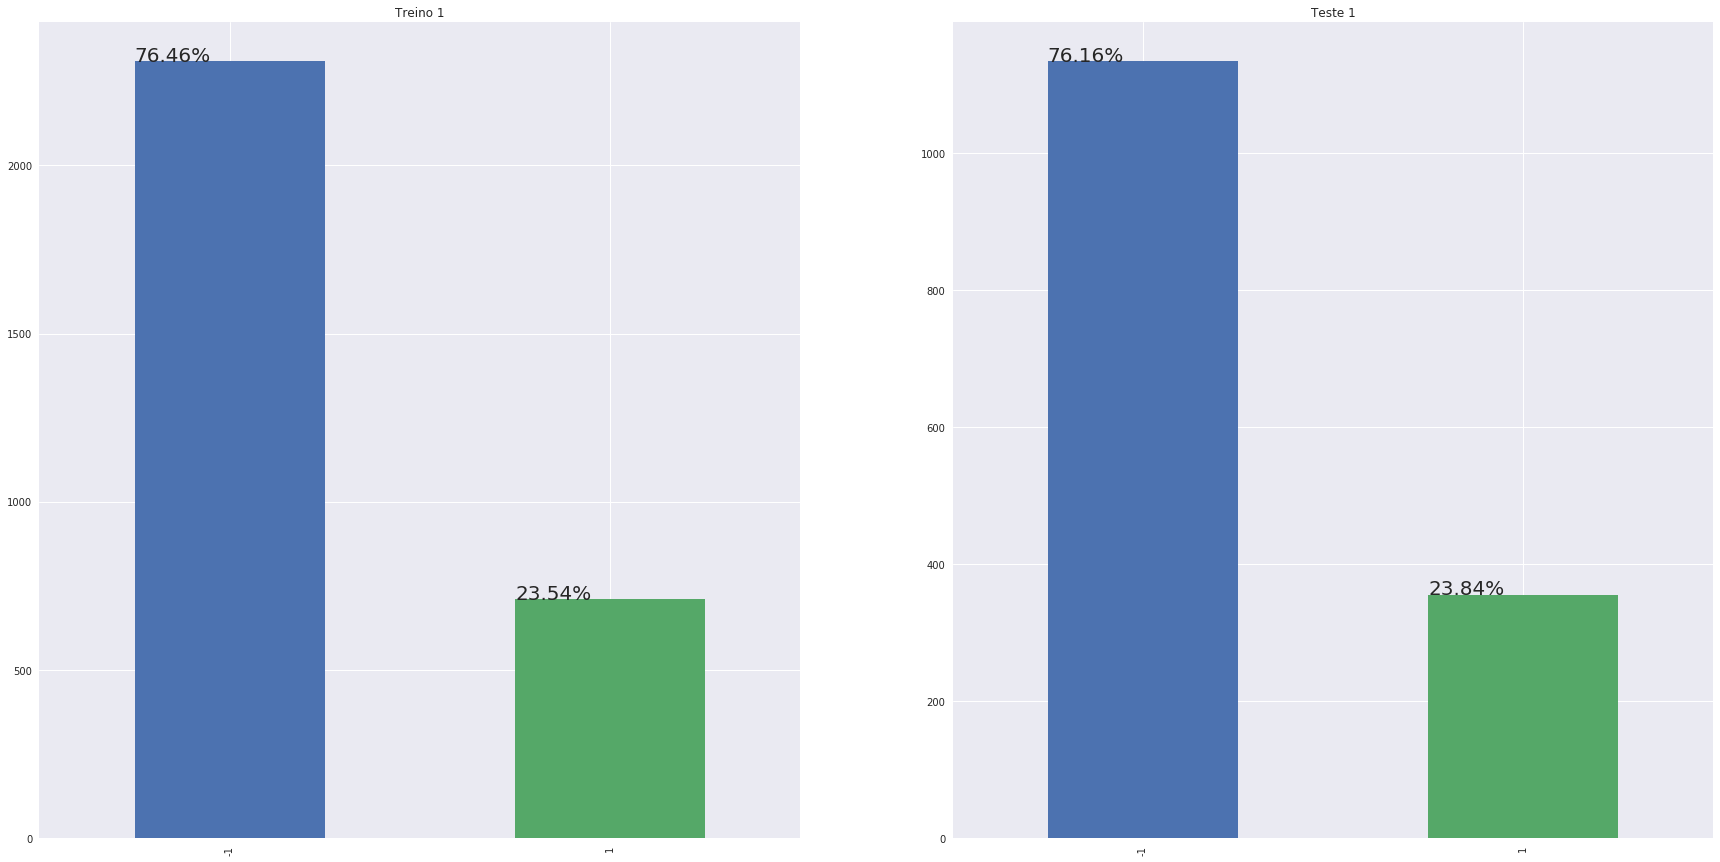

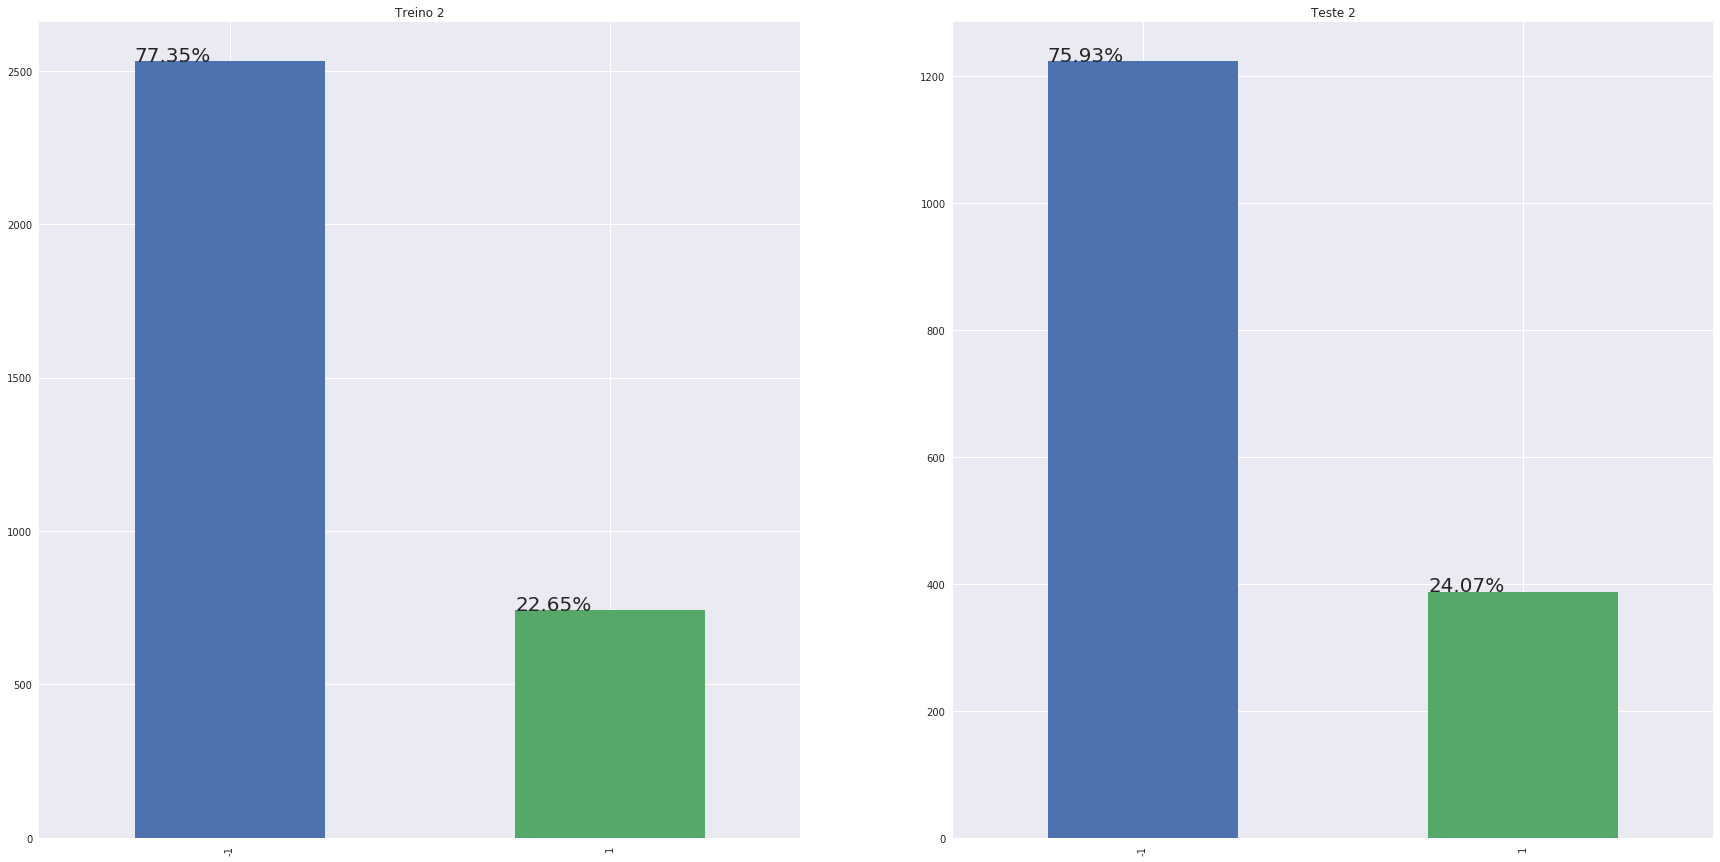

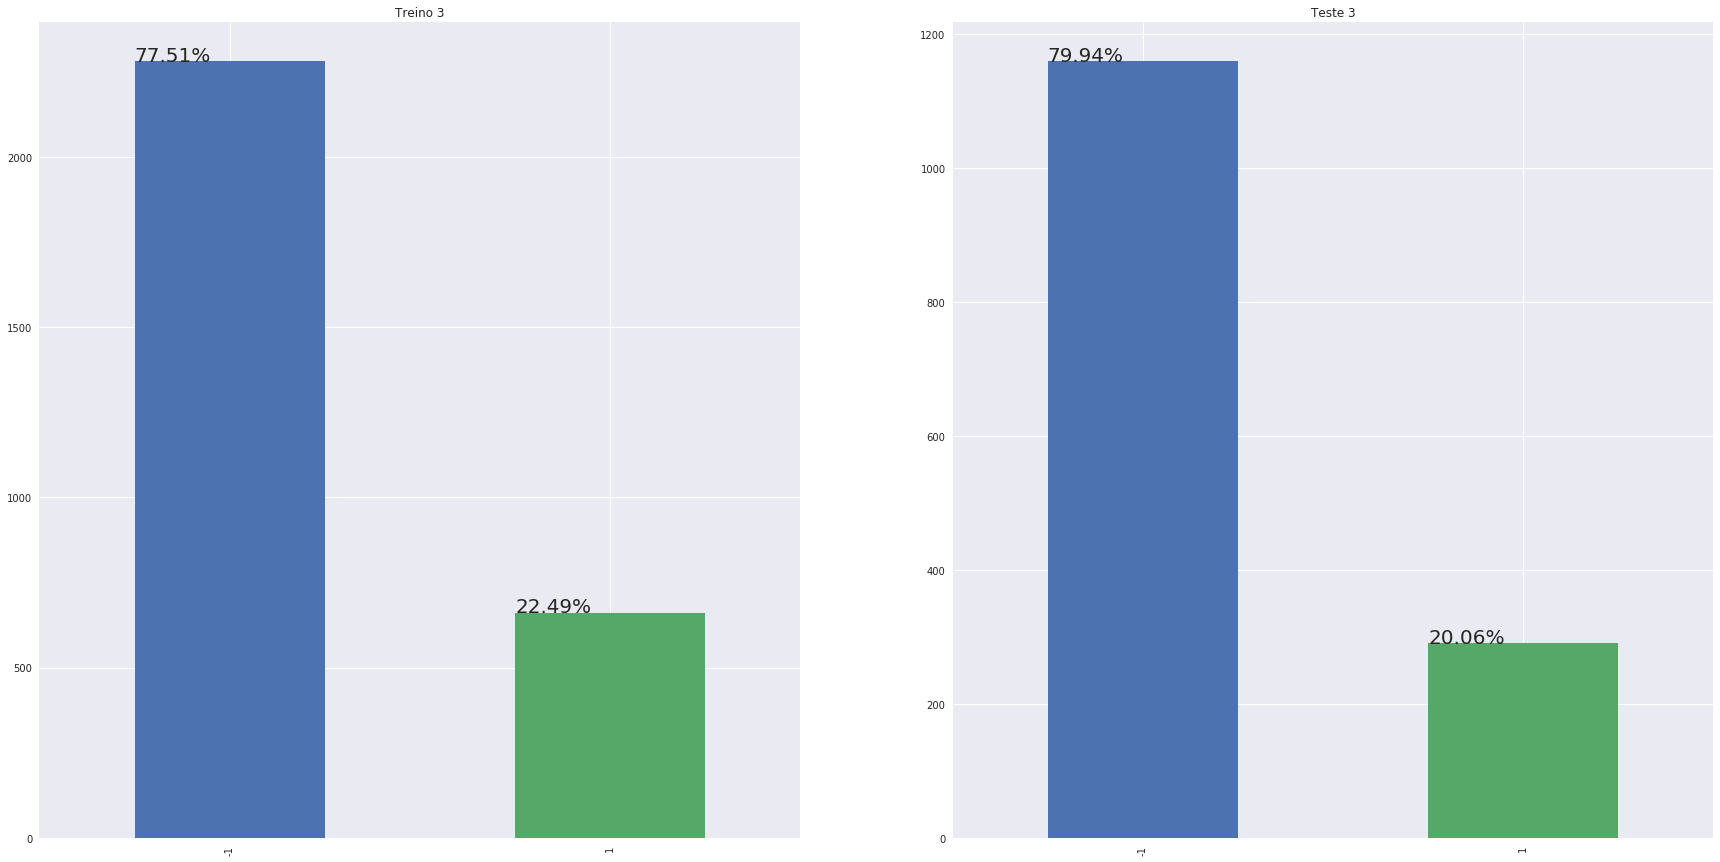

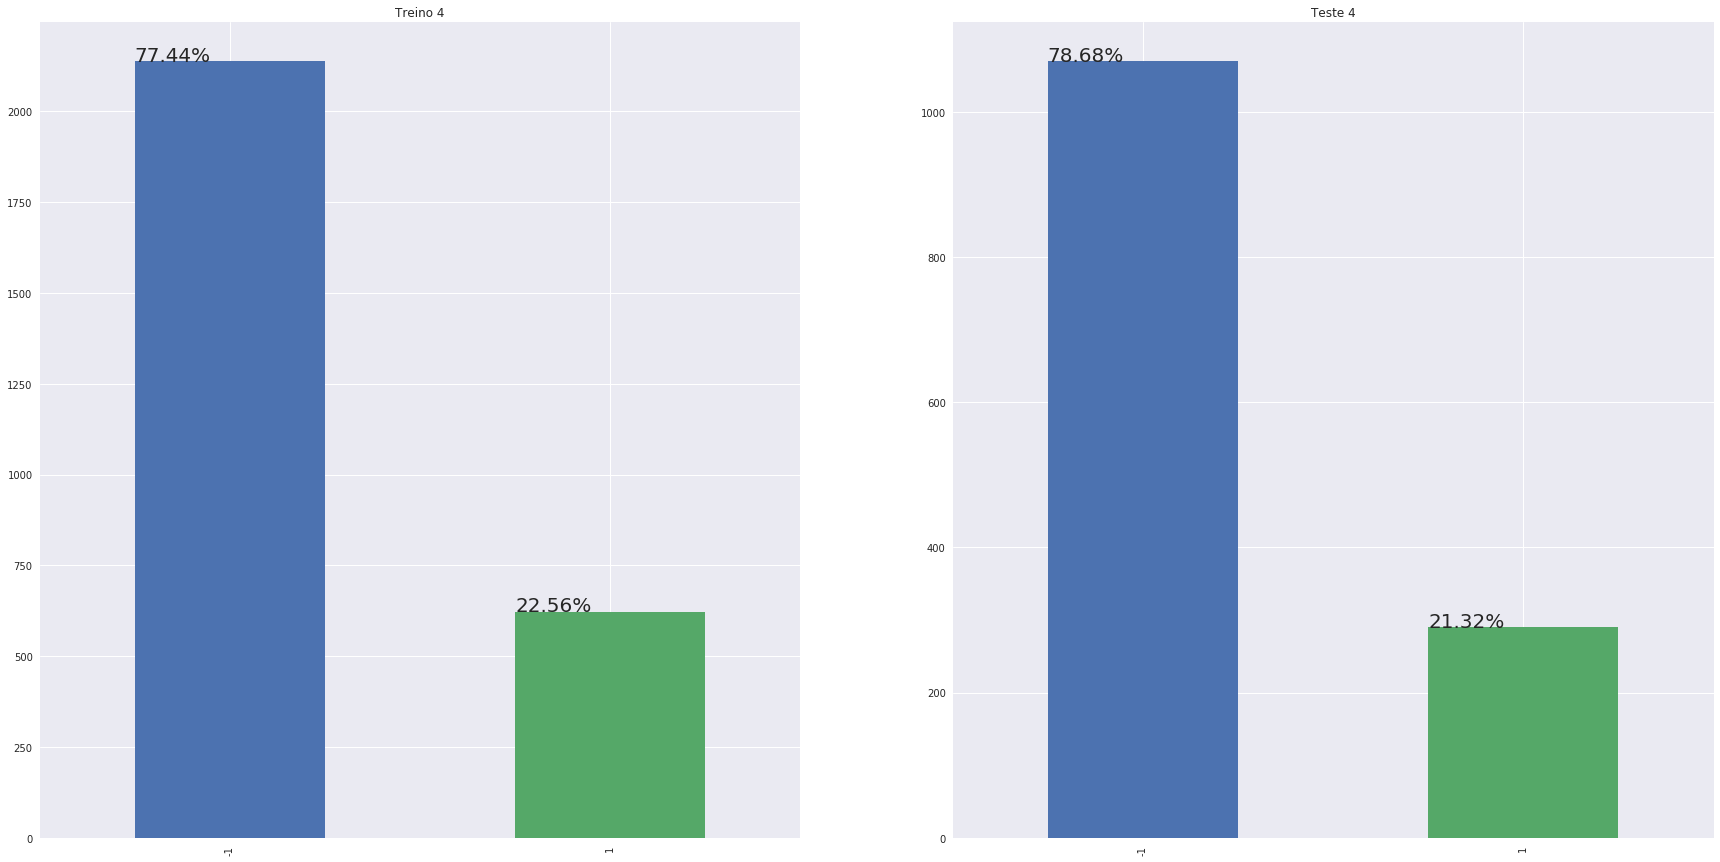

In [3]:
# Checando a distribuição dos targets em cada conjunto (treino e teste) de cada abordagem

sns.set(style='darkgrid')
temp_train = [train_target_1, train_target_2, train_target_3, train_target_4]
temp_test = [test_target_1, test_target_2, test_target_3, test_target_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

In [8]:
# Importando módulos da rede neural

from sklearn.neural_network import MLPClassifier 

# Definindo os parâmetros do modelo e possíveis valores

# param_grid_one = {'hidden_layer_sizes': list(zip(map(int,np.logspace(start=1,stop=7,num=7,base=2)))), 
#                   'alpha': list(np.logspace(start=-4,stop=1,num=6,base=10))}

param_grid_one = {'hidden_layer_sizes': list(zip(map(int,np.logspace(start=1,stop=12,num=12,base=2)))), 
                  'alpha': list(np.logspace(start=-5,stop=2,num=8,base=10))}

# print(param_grid_one)

# param_grid_two = {'hidden_layer_sizes': [ (a,b) for a in list(map(int,np.logspace(start=1,stop=7,num=7,base=2))) for b in list(map(int,np.logspace(start=1,stop=7,num=7,base=2))) ],
#                   'alpha': list(np.logspace(start=-4,stop=1,num=6,base=10))}

# print(param_grid_two)

mlp = MLPClassifier(activation='logistic',batch_size=16, max_iter=10000, solver='sgd')

# Validação cruzada com cada conjunto de parâmetros

clf_one = GridSearchCV(mlp,param_grid_one,return_train_score=True,cv=10,
                   scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision'], refit=False, n_jobs=-1)
              
# clf_two = GridSearchCV(mlp,param_grid_two,return_train_score=True,cv=10,
#                    scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision'], refit=False)

#### Treinamento

In [18]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 1: Retirar os valores faltantes e manter outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

clf_one.fit(pd.get_dummies(train_data_1), train_target_1) # Classes desbalanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_one.fit(train_data_b_1, train_target_b_1) # Classes balanceadas
# joblib.dump(clf_one, 
#             path_arquivos+'mlp-one-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_1), train_target_1)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-one-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_1, train_target_b_1)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-one-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada



['Classificadores/Redes-neurais-MLP/mlp-one-abordagem-1-desbalanceado-dataset-10pct.pkl']

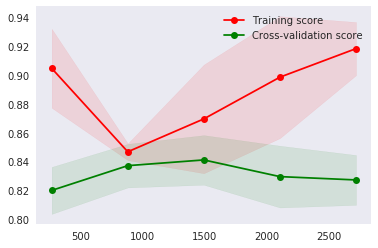

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
        mlp, pd.get_dummies(train_data_1), train_target_1, cv=10, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")

0
1


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


ValueError: x and y must have same first dimension, but have shapes (1,) and (2000,)

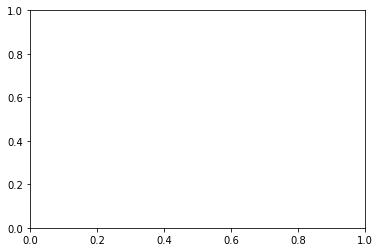

In [5]:
max_epochs = 2000

epoch = 0

scores_training = []
scores_test = []

while epoch < max_epochs:
    
    print(epoch)
    mlp.fit(pd.get_dummies(train_data_1), train_target_1)
    scores_training.append(mlp.score(pd.get_dummies(train_data_1), train_target_1))
    scores_test.append(mlp.score(pd.get_dummies(test_data_1), test_target_1))
#     results = pd.DataFrame(clf_one.cv_results_)
#     results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
#     results_train = results_test.filter(regex=(".*train.*"))
#     results_test.drop(columns=results_train.columns,inplace=True)
#     results_test_filtered = results_test.filter(regex='.*_test_accuracy').transpose()
#     results_train_filtered = results_train.filter(regex='.*_train_accuracy').transpose()
#     scores_training.append(results_train_filtered.mean())
#     scores_test.append(results_test_filtered.mean())
    epoch += 1
    
plt.plot(np.arange(1,max_epochs+1), scores_training, label='Treino', color='blue', lw=2)
plt.plot(np.arange(1,max_epochs+1), scores_test, label='Validação', color='green', lw=2)
plt.legend(loc='best')

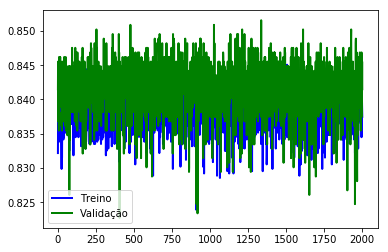

In [20]:
plt.plot(np.arange(1,max_epochs+1), scores_training, label='Treino', color='blue', lw=2)
plt.plot(np.arange(1,max_epochs+1), scores_test, label='Validação', color='green', lw=2)
plt.legend(loc='best')
plt.show()

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


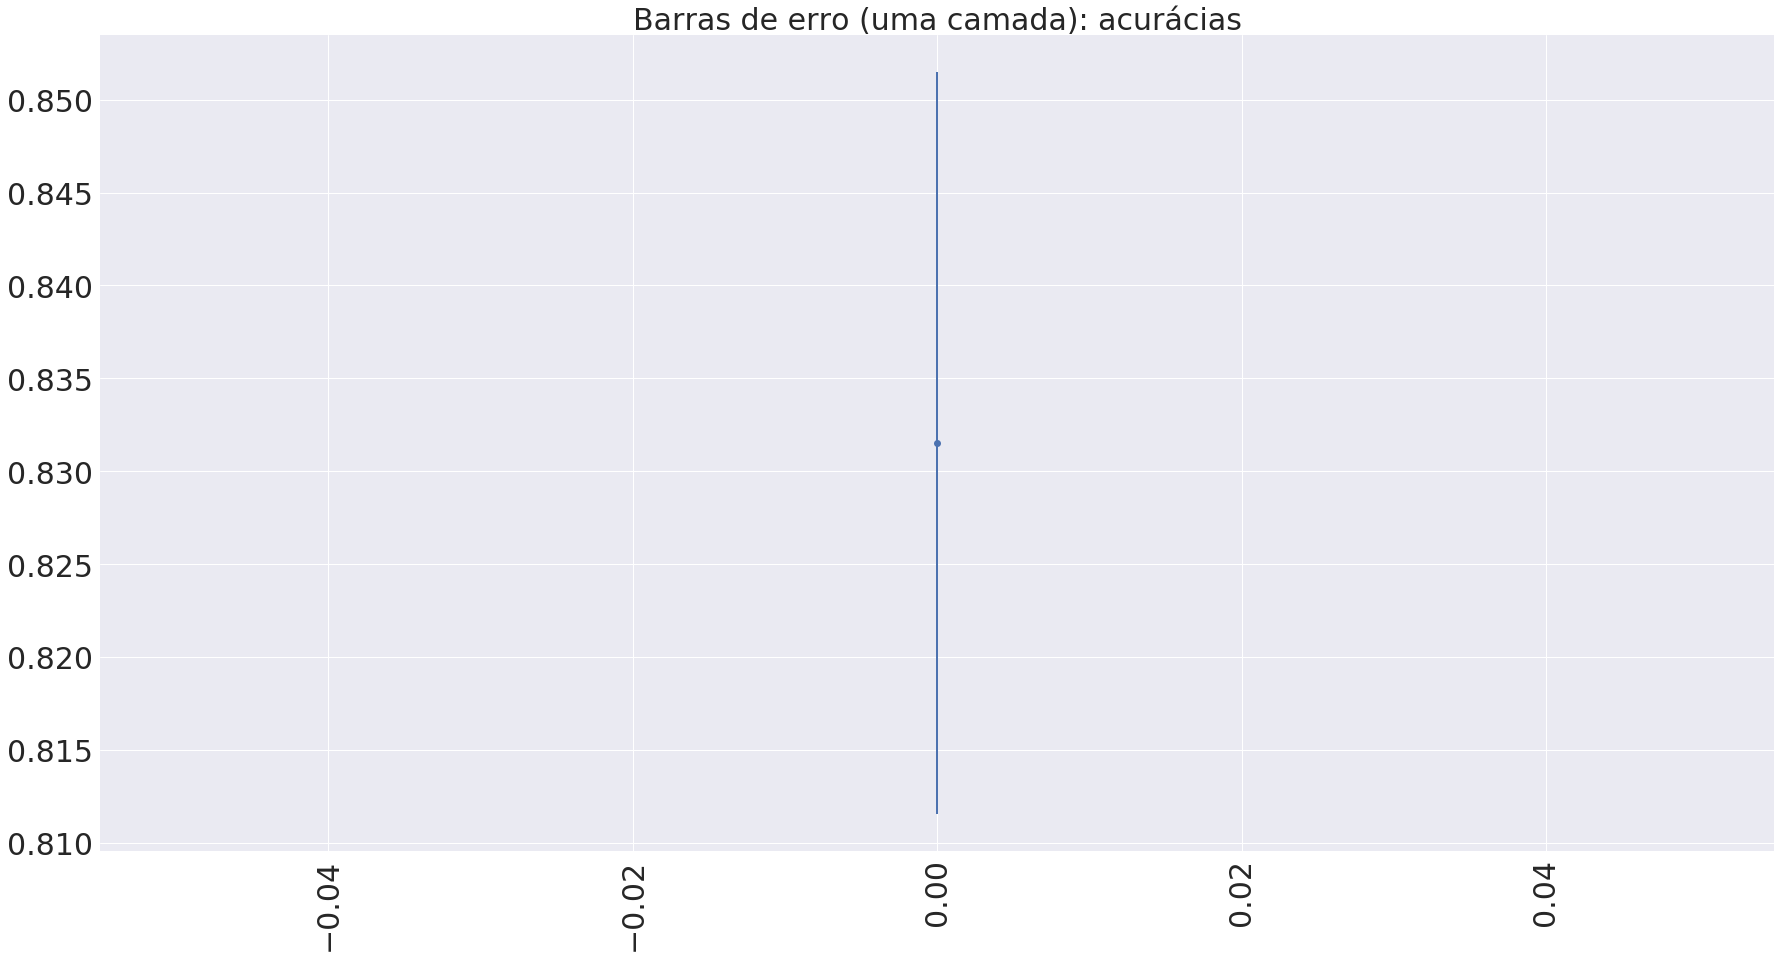

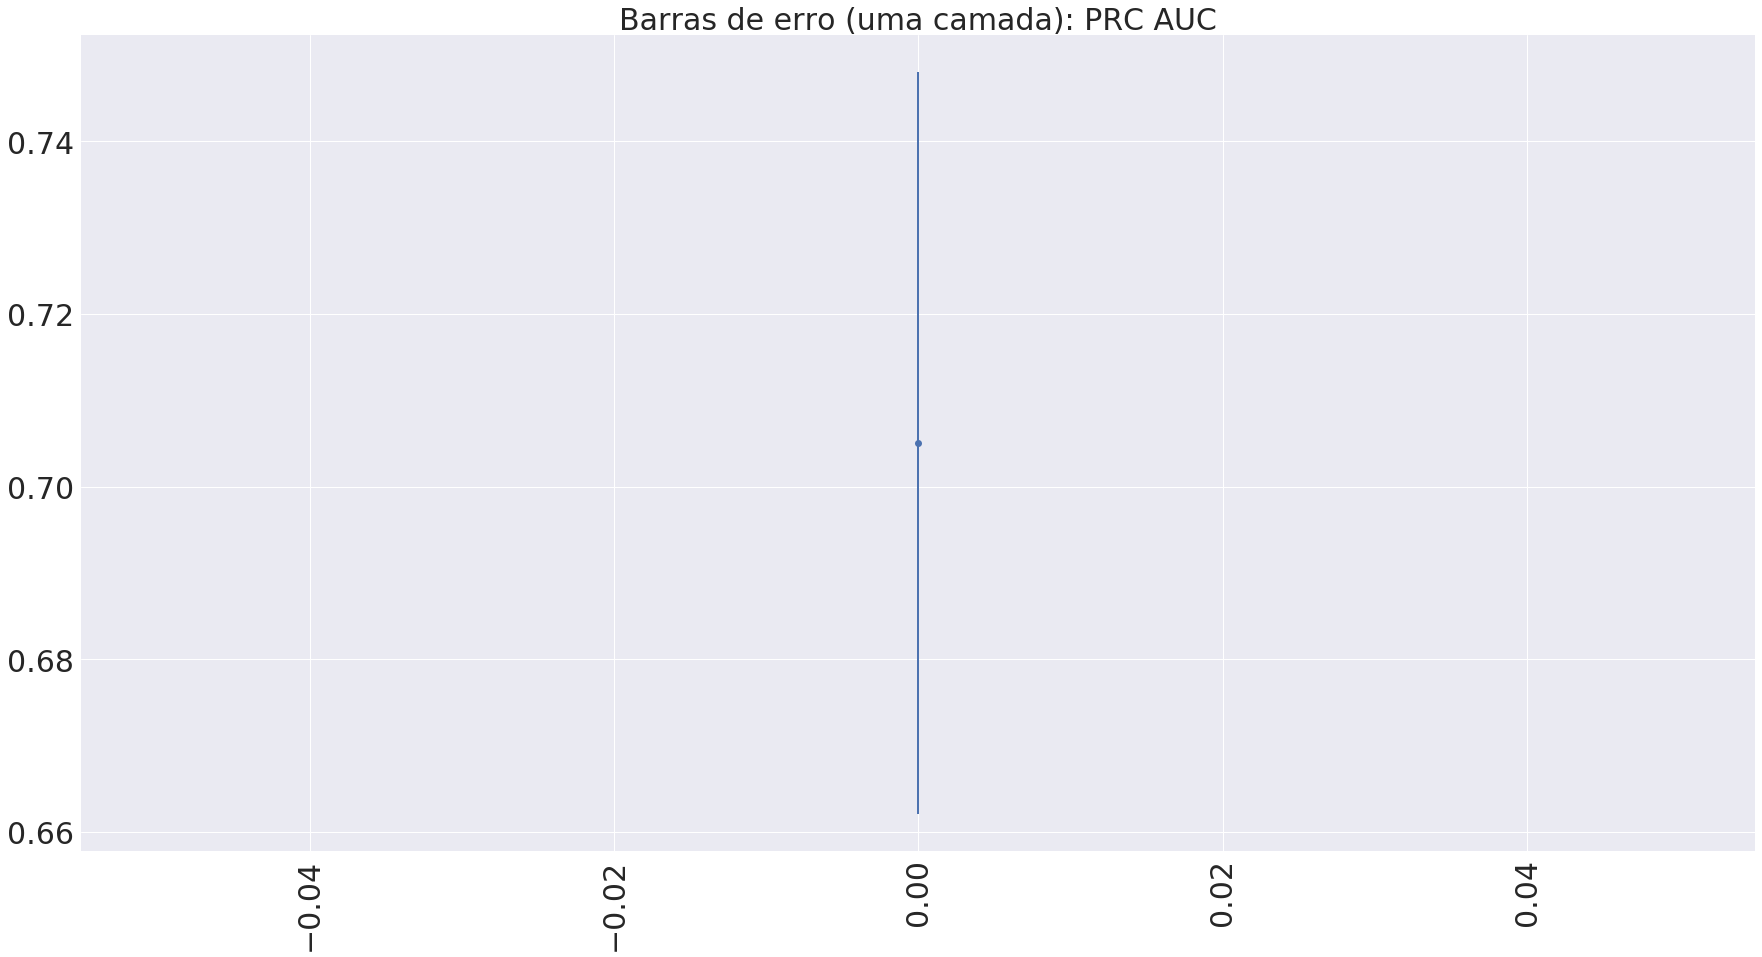

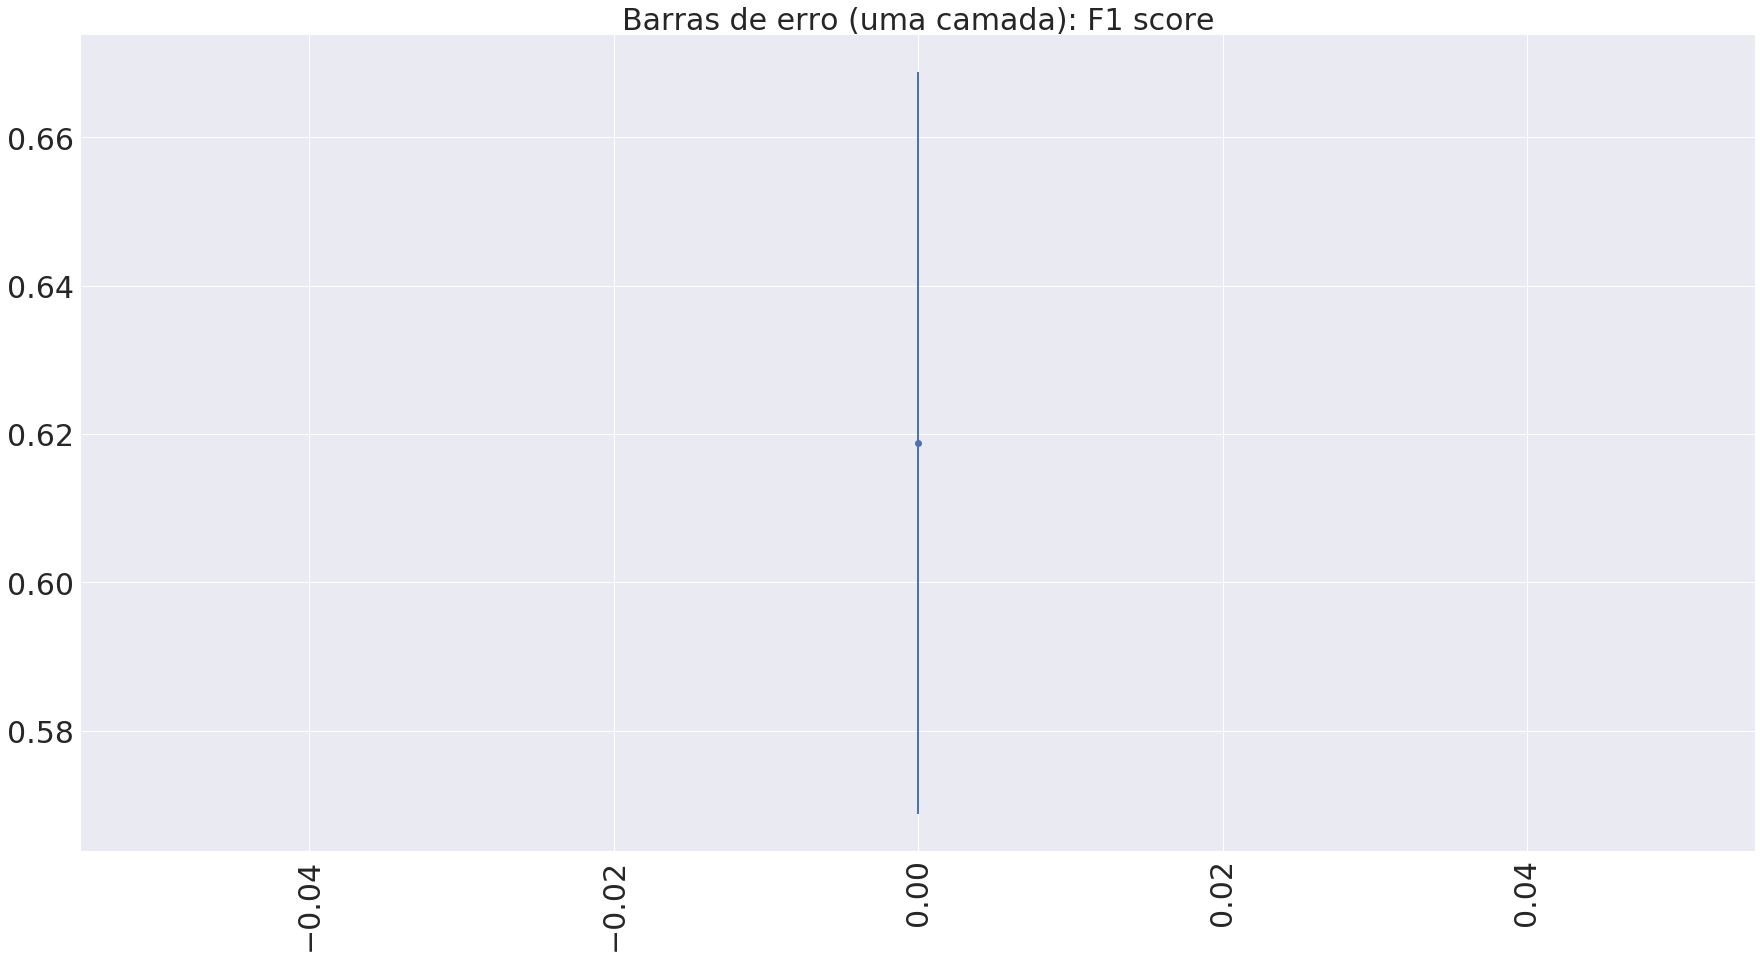

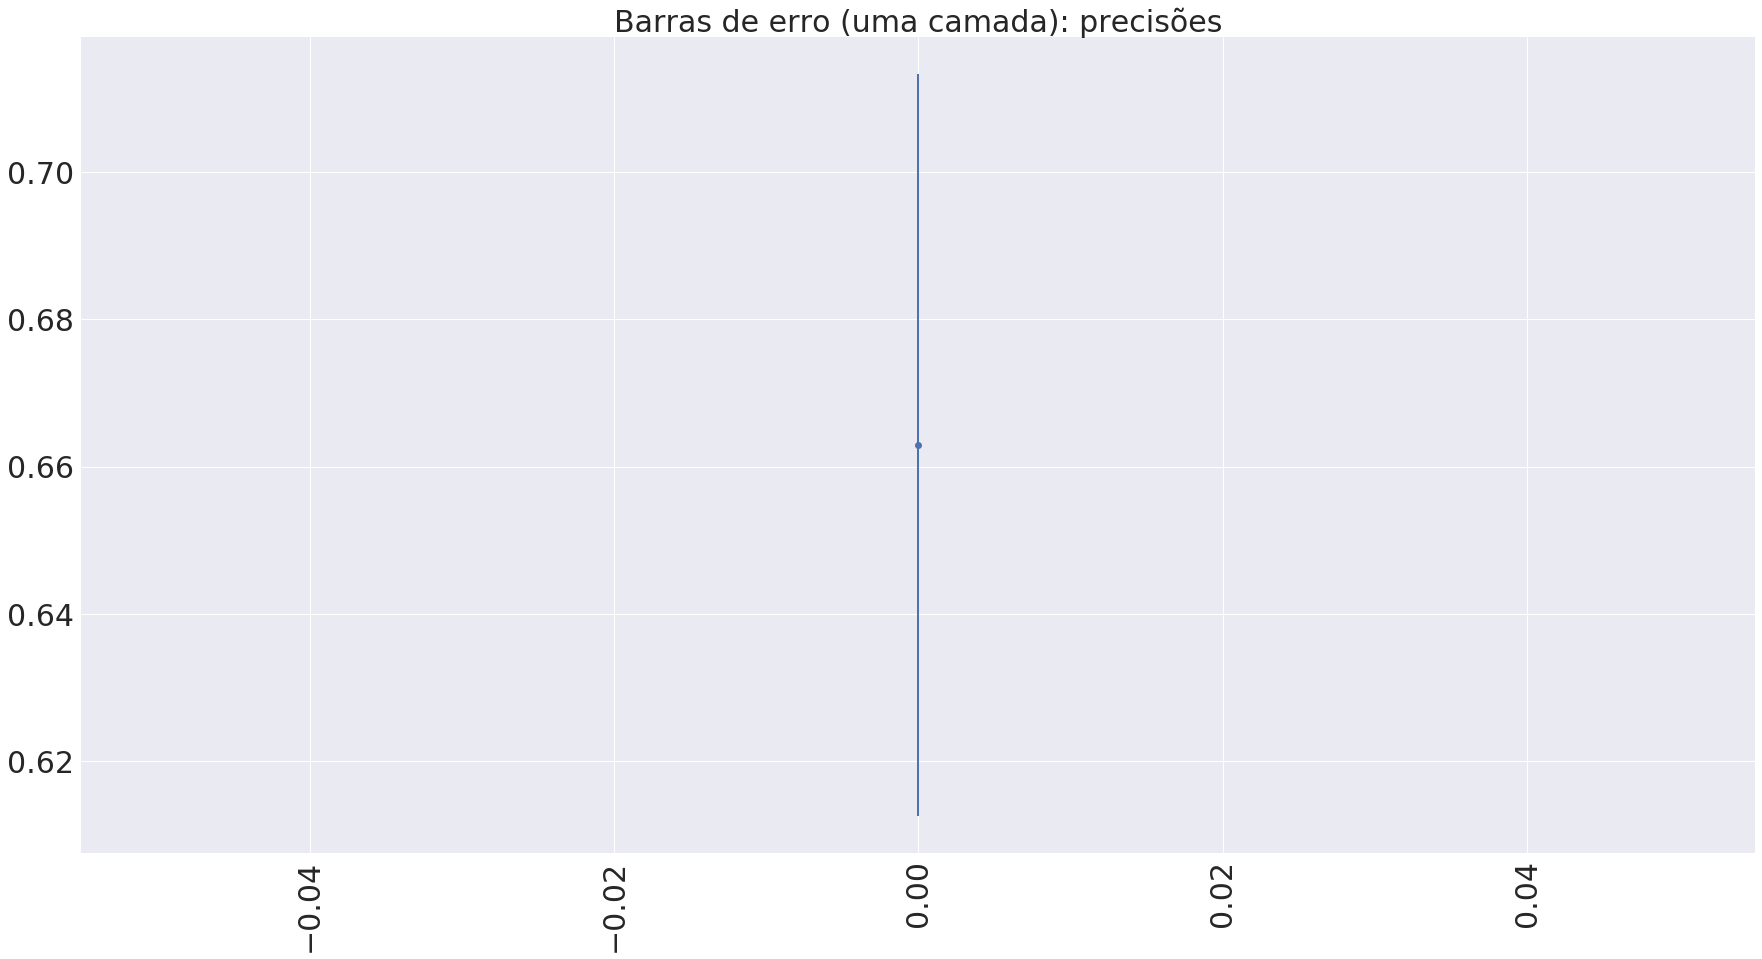

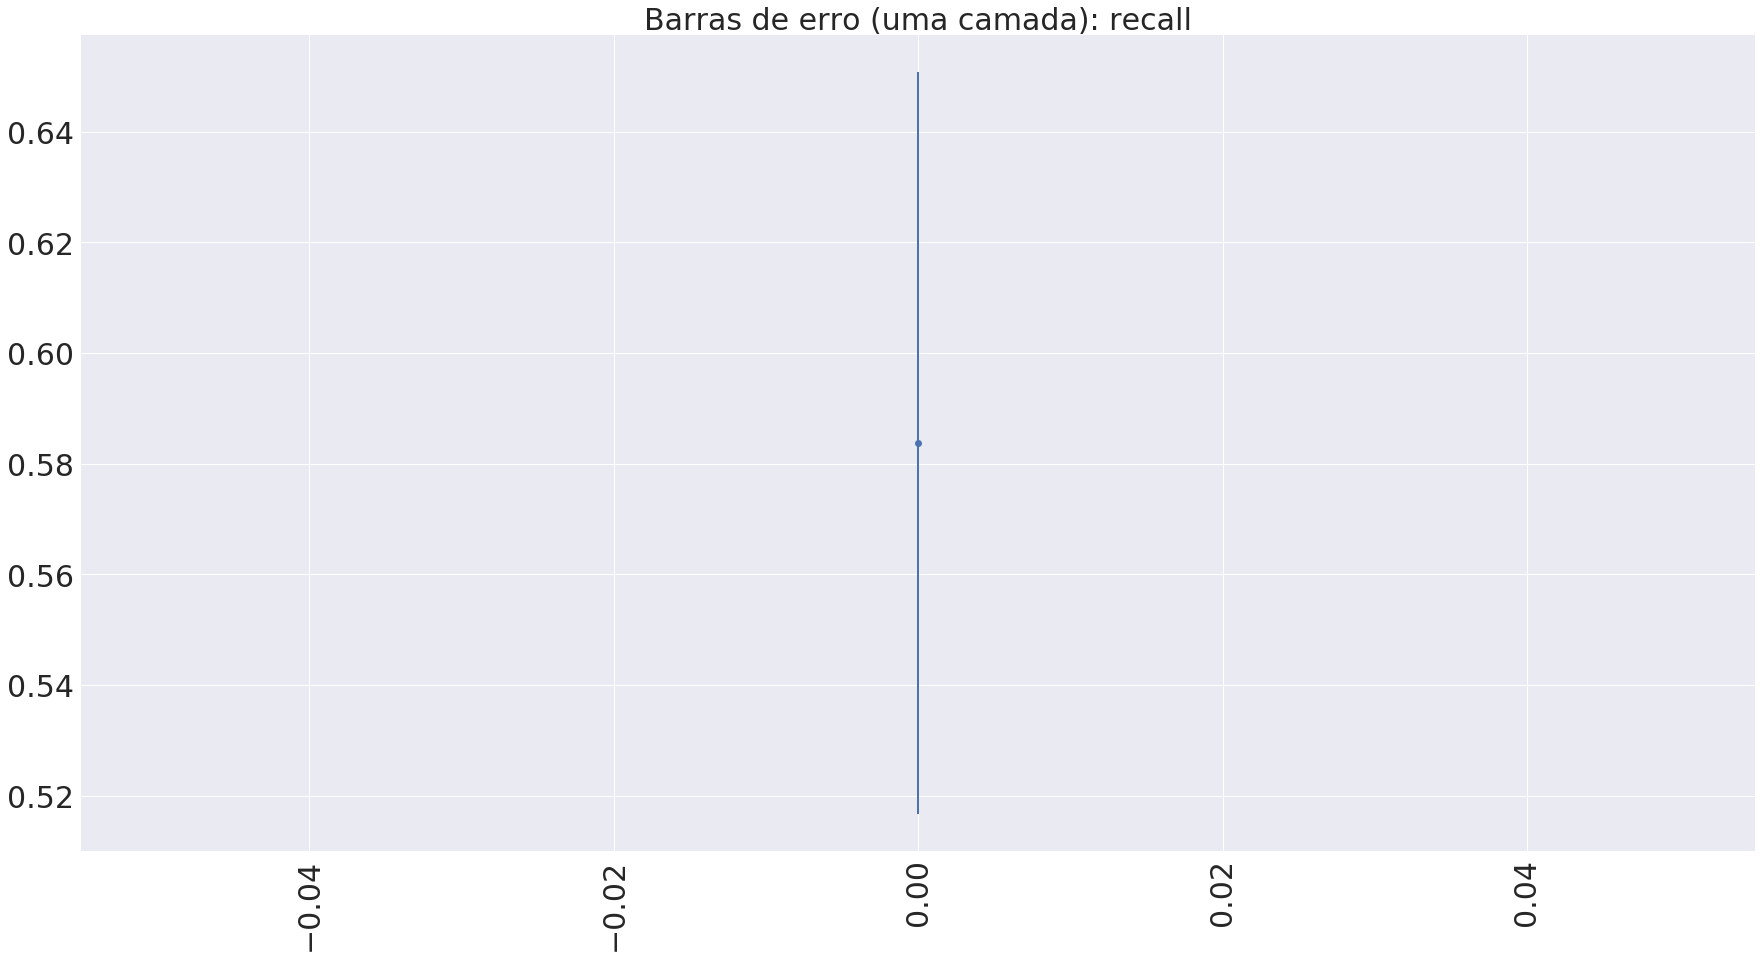

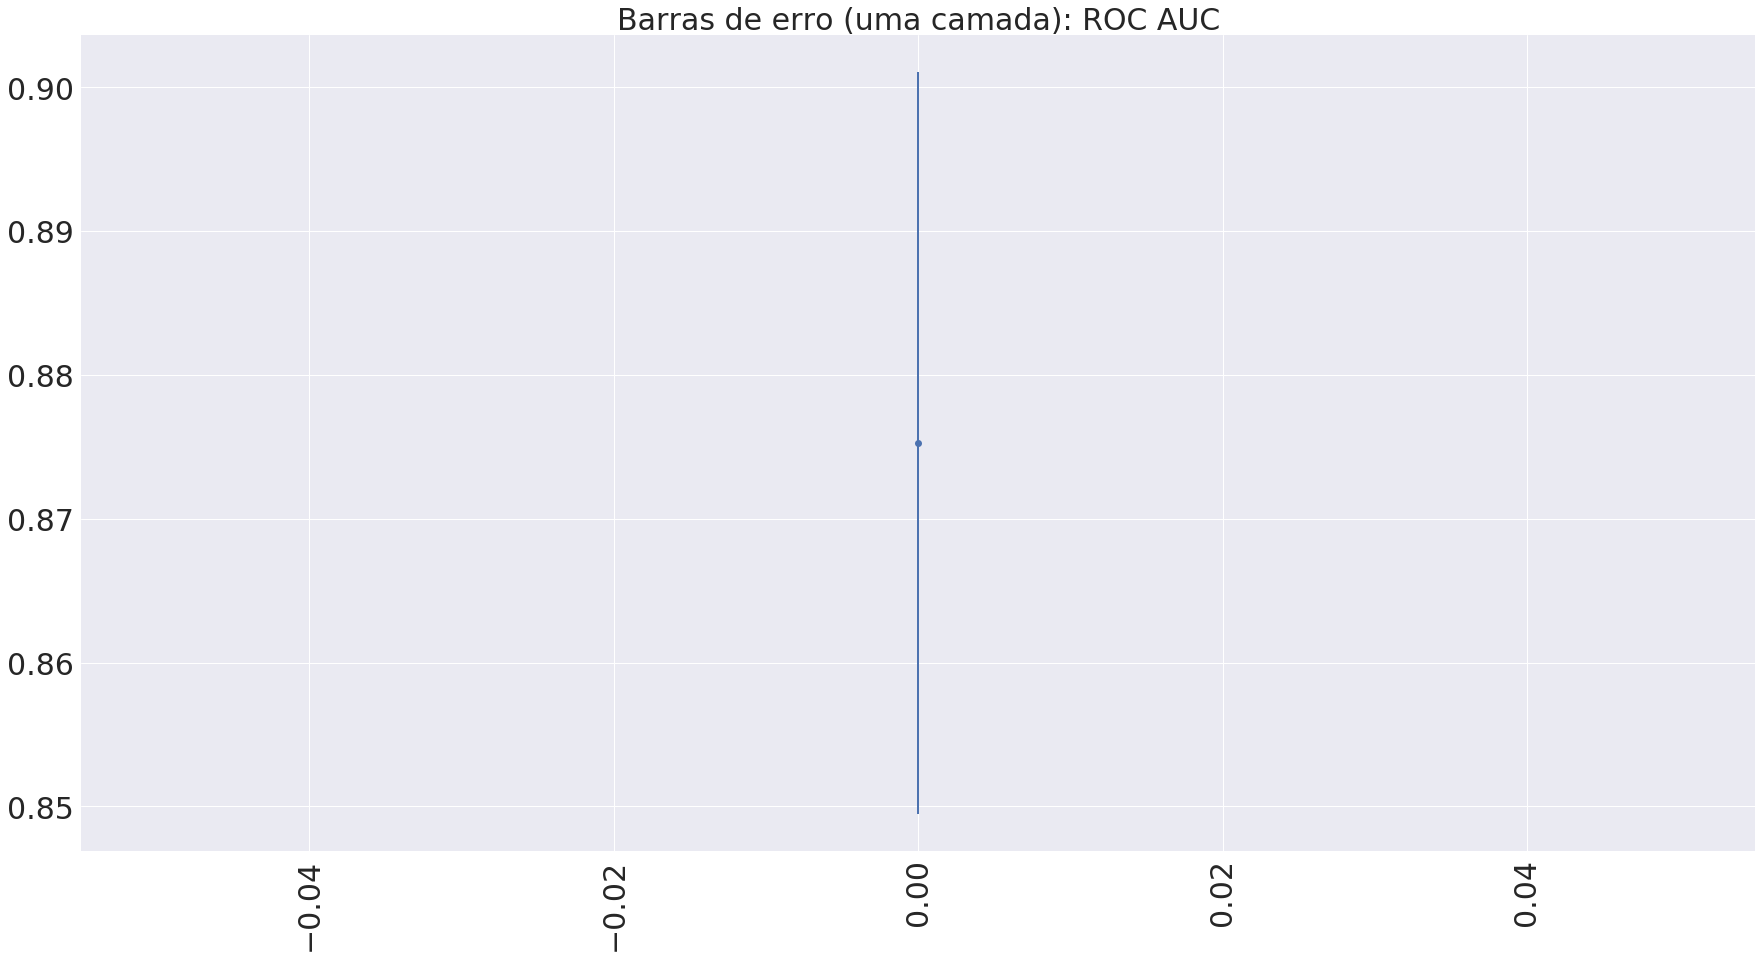

In [19]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

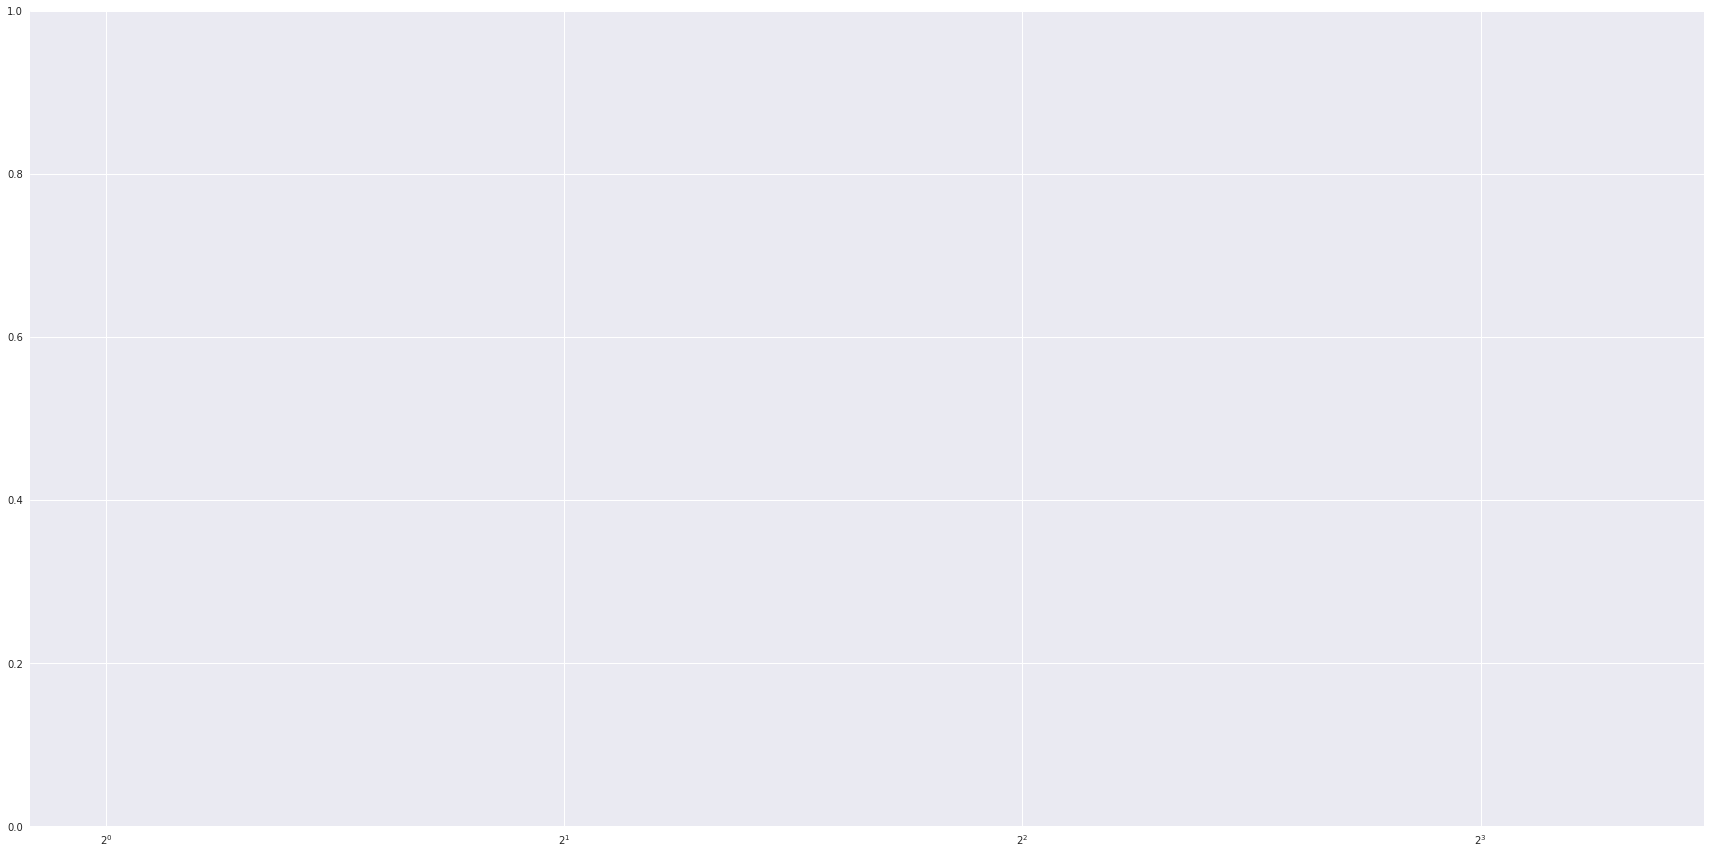

In [16]:
n_neurons = list(map(int,(np.logspace(start=1,stop=7,num=7,base=2))))
    
# display(results_train.head())    

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
    results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()
    
#     display(results_train_filtered.head(10))

#         results_test_filtered = results_test_filtered.iloc[:, 0:int((results_test_filtered.shape[1]/2))]
#         results_train_filtered = results_train_filtered.iloc[:, 0:int((results_train_filtered.shape[1]/2))]

#     display(results_train_filtered.head())

    results_test_filtered = results_test_filtered.iloc[:, 0:7]
    results_train_filtered = results_train_filtered.iloc[:, 0:7]
    
    
    fig = plt.figure(figsize=(30,15))
    plt.semilogx(n_neurons, results_test_filtered.mean(), label='Validação', color='green', lw=2, basex=2)
    plt.fill_between(n_neurons, results_test_filtered.mean() - results_test_filtered.std(),
                     results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

    plt.semilogx(n_neurons, results_train_filtered.mean(), label='Treino', color='blue', lw=2, basex=2)
    plt.fill_between(n_neurons, results_train_filtered.mean() - results_train_filtered.std(),
                     results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)
    plt.title('Curvas de validação: '+ metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.xlabel('Número de neurônios', fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc='best', fontsize=30)
    plt.show()

In [12]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 2: Imputar os valores faltantes e manter outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

clf_one.fit(pd.get_dummies(train_data_2), train_target_2) # Classes desbalanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_one.fit(train_data_b_2, train_target_b_2) # Classes balanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_2), train_target_2)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_2, train_target_b_2)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined a

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fcb2536aed0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/netware/users/gustavomn/.conda/envs/data-m...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/netware/users/gustavomn/.conda/envs/data-m...lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/netwar.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fcb2536aed0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/netware/users/gustavomn/.conda/envs/data-m...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/netware/users/gustavomn/.conda/envs/data-m...lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/netwar.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except (RuntimeError, AssertionError):
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1421                         logger.warning('Executing %s took %.3f seconds',
   1422                                        _format_handle(handle), dt)
   1423                 finally:
   1424                     self._current_handle = None
   1425             else:
-> 1426                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(14, 1)>>
   1427         handle = None  # Needed to break cycles when an exception occurs.
   1428 
   1429     def _set_coroutine_wrapper(self, enabled):
   1430         try:

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(14, 1)>)
    122             self._callback = None
    123             self._args = None
    124 
    125     def _run(self):
    126         try:
--> 127             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (14, 1)
    128         except Exception as exc:
    129             cb = _format_callback_source(self._callback, self._args)
    130             msg = 'Exception in callback {}'.format(cb)
    131             context = {

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=14, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 29, 19, 40, 28, 808277, tzinfo=tzutc()), 'msg_id': '042543f9d40b4f75823b6118f9afcf7e', 'msg_type': 'execute_request', 'session': 'aedb9a34ad8148dc8dc73c04feb0262b', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '042543f9d40b4f75823b6118f9afcf7e', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'aedb9a34ad8148dc8dc73c04feb0262b']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 29, 19, 40, 28, 808277, tzinfo=tzutc()), 'msg_id': '042543f9d40b4f75823b6118f9afcf7e', 'msg_type': 'execute_request', 'session': 'aedb9a34ad8148dc8dc73c04feb0262b', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '042543f9d40b4f75823b6118f9afcf7e', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'aedb9a34ad8148dc8dc73c04feb0262b'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 29, 19, 40, 28, 808277, tzinfo=tzutc()), 'msg_id': '042543f9d40b4f75823b6118f9afcf7e', 'msg_type': 'execute_request', 'session': 'aedb9a34ad8148dc8dc73c04feb0262b', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '042543f9d40b4f75823b6118f9afcf7e', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="# Descomentar somente se for necessário retreina...') # Salvando os resultados da validação cruzada\n", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-12-81e1993cc3cc>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fcb18c057b8, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fcad87e3030, file "<ipython-input-12-81e1993cc3cc>", line 11>
        result = <ExecutionResult object at 7fcb18c057b8, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fcad87e3030, file "<ipython-input-12-81e1993cc3cc>", line 11>, result=<ExecutionResult object at 7fcb18c057b8, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fcad87e3030, file "<ipython-input-12-81e1993cc3cc>", line 11>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Importando os arquivos com os datasets pré-pro..., inplace=True)\n\ndisplay(train_target_1.unique())', '# Importando os módulos necessários para o proce...et que está sendo utilizada\n\nfracao_dataset = 0.1', '# Importando os arquivos com os datasets pré-pro..., inplace=True)\n\ndisplay(train_target_1.unique())', '# Importando os arquivos com os datasets pré-pro..., inplace=True)\n\ndisplay(train_target_2.unique())', '# Importando os arquivos com os datasets pré-pro...e=True)\ntest_target_4.replace(-1,0, inplace=True)', "# Importando módulos da rede neural\n\nfrom sklear...oc_auc', 'f1', 'average_precision'], refit=False)", "# Importando módulos da rede neural\n\nfrom sklear...oc_auc', 'f1', 'average_precision'], refit=False)", "# Importando módulos da rede neural\n\nfrom sklear...oc_auc', 'f1', 'average_precision'], refit=False)", 'display(train_target_b_2)', 'display(train_target_b_2.unique())', 'display(train_target_2.unique())', "# Descomentar somente se for necessário retreina...l') # Salvando os resultados da validação cruzada"], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'MLPClassifier': <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>, 'Out': {}, 'ParameterGrid': <class 'sklearn.model_selection._search.ParameterGrid'>, 'SMOTE': <class 'imblearn.over_sampling.smote.SMOTE'>, '_': '', '__': '', '___': '', ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Importando os arquivos com os datasets pré-pro..., inplace=True)\n\ndisplay(train_target_1.unique())', '# Importando os módulos necessários para o proce...et que está sendo utilizada\n\nfracao_dataset = 0.1', '# Importando os arquivos com os datasets pré-pro..., inplace=True)\n\ndisplay(train_target_1.unique())', '# Importando os arquivos com os datasets pré-pro..., inplace=True)\n\ndisplay(train_target_2.unique())', '# Importando os arquivos com os datasets pré-pro...e=True)\ntest_target_4.replace(-1,0, inplace=True)', "# Importando módulos da rede neural\n\nfrom sklear...oc_auc', 'f1', 'average_precision'], refit=False)", "# Importando módulos da rede neural\n\nfrom sklear...oc_auc', 'f1', 'average_precision'], refit=False)", "# Importando módulos da rede neural\n\nfrom sklear...oc_auc', 'f1', 'average_precision'], refit=False)", 'display(train_target_b_2)', 'display(train_target_b_2.unique())', 'display(train_target_2.unique())', "# Descomentar somente se for necessário retreina...l') # Salvando os resultados da validação cruzada"], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'MLPClassifier': <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>, 'Out': {}, 'ParameterGrid': <class 'sklearn.model_selection._search.ParameterGrid'>, 'SMOTE': <class 'imblearn.over_sampling.smote.SMOTE'>, '_': '', '__': '', '___': '', ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/netware/users/gustavomn/Data Mining/trabalho/repo/adult-dataset/<ipython-input-12-81e1993cc3cc> in <module>()
      6 
      7 clf_one.fit(pd.get_dummies(train_data_2), train_target_2) # Classes desbalanceadas
      8 joblib.dump(clf_one, 
      9             path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada
     10 
---> 11 clf_one.fit(train_data_b_2, train_target_b_2) # Classes balanceadas
     12 joblib.dump(clf_one, 
     13             path_arquivos+'mlp-one-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada
     14 
     15 # clf_two.fit(pd.get_dummies(train_data_2), train_target_2)

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=10, error_score='raise',
       ...c', 'f1', 'average_precision'],
       verbose=0), X=           age    fnlwgt  hours-per-week  invest...rth-America         1  

[5062 rows x 13 columns], y=4178    1
2739    0
3346    1
2575    0
783     ...4    1
Name: earnings, Length: 5062, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...d(n_splits=10, random_state=None, shuffle=False)>
        X =            age    fnlwgt  hours-per-week  invest...rth-America         1  

[5062 rows x 13 columns]
        y = 4178    1
2739    0
3346    1
2575    0
783     ...4    1
Name: earnings, Length: 5062, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue May 29 18:43:19 2018
PID: 26300Python 3.6.2: /home/netware/users/gustavomn/.conda/envs/data-mining-coc800/bin/python3
...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False),            age    fnlwgt  hours-per-week  invest...rth-America         1  

[5062 rows x 13 columns], 4178    1
2739    0
3346    1
2575    0
783     ...4    1
Name: earnings, Length: 5062, dtype: int64, {'accuracy': make_scorer(accuracy_score), 'average_precision': make_scorer(average_precision_score, needs_threshold=True), 'f1': make_scorer(f1_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 488,  490,  491, ..., 5059, 5060, 5061]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 517, 518, 522, 524, 528, 530, 531,
       538]), 0, {'alpha': 1e-05, 'hidden_layer_sizes': (2,)}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False),            age    fnlwgt  hours-per-week  invest...rth-America         1  

[5062 rows x 13 columns], 4178    1
2739    0
3346    1
2575    0
783     ...4    1
Name: earnings, Length: 5062, dtype: int64, {'accuracy': make_scorer(accuracy_score), 'average_precision': make_scorer(average_precision_score, needs_threshold=True), 'f1': make_scorer(f1_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 488,  490,  491, ..., 5059, 5060, 5061]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 517, 518, 522, 524, 528, 530, 531,
       538]), 0, {'alpha': 1e-05, 'hidden_layer_sizes': (2,)})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False), X=           age    fnlwgt  hours-per-week  invest...rth-America         1  

[5062 rows x 13 columns], y=4178    1
2739    0
3346    1
2575    0
783     ...4    1
Name: earnings, Length: 5062, dtype: int64, scorer={'accuracy': make_scorer(accuracy_score), 'average_precision': make_scorer(average_precision_score, needs_threshold=True), 'f1': make_scorer(f1_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([ 488,  490,  491, ..., 5059, 5060, 5061]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 517, 518, 522, 524, 528, 530, 531,
       538]), verbose=0, parameters={'alpha': 1e-05, 'hidden_layer_sizes': (2,)}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method MLPClassifier.fit of MLPClassifier...ion=0.1,
       verbose=False, warm_start=False)>
        X_train =            age    fnlwgt  hours-per-week  invest...rth-America         1  

[4554 rows x 13 columns]
        y_train = 3559    1
3827    1
2668    1
4343    1
4406    ...4    1
Name: earnings, Length: 4554, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py in fit(self=MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False), X=           age    fnlwgt  hours-per-week  invest...rth-America         1  

[4554 rows x 13 columns], y=3559    1
3827    1
2668    1
4343    1
4406    ...4    1
Name: earnings, Length: 4554, dtype: int64)
    968         Returns
    969         -------
    970         self : returns a trained MLP model.
    971         """
    972         return self._fit(X, y, incremental=(self.warm_start and
--> 973                                             hasattr(self, "classes_")))
        self = MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False)
    974 
    975     @property
    976     def partial_fit(self):
    977         """Fit the model to data matrix X and target y.

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py in _fit(self=MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False), X=           age    fnlwgt  hours-per-week  invest...rth-America         1  

[4554 rows x 13 columns], y=3559    1
3827    1
2668    1
4343    1
4406    ...4    1
Name: earnings, Length: 4554, dtype: int64, incremental=False)
    326         self._validate_hyperparameters()
    327         if np.any(np.array(hidden_layer_sizes) <= 0):
    328             raise ValueError("hidden_layer_sizes must be > 0, got %s." %
    329                              hidden_layer_sizes)
    330 
--> 331         X, y = self._validate_input(X, y, incremental)
        X =            age    fnlwgt  hours-per-week  invest...rth-America         1  

[4554 rows x 13 columns]
        y = 3559    1
3827    1
2668    1
4343    1
4406    ...4    1
Name: earnings, Length: 4554, dtype: int64
        self._validate_input = <bound method MLPClassifier._validate_input of M...ion=0.1,
       verbose=False, warm_start=False)>
        incremental = False
    332         n_samples, n_features = X.shape
    333 
    334         # Ensure y is 2D
    335         if y.ndim == 1:

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py in _validate_input(self=MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False), X=           age    fnlwgt  hours-per-week  invest...rth-America         1  

[4554 rows x 13 columns], y=3559    1
3827    1
2668    1
4343    1
4406    ...4    1
Name: earnings, Length: 4554, dtype: int64, incremental=False)
    905                      validation_fraction=validation_fraction,
    906                      beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    907 
    908     def _validate_input(self, X, y, incremental):
    909         X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'],
--> 910                          multi_output=True)
    911         if y.ndim == 2 and y.shape[1] == 1:
    912             y = column_or_1d(y, warn=True)
    913 
    914         if not incremental:

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/utils/validation.py in check_X_y(X=           age    fnlwgt  hours-per-week  invest...rth-America         1  

[4554 rows x 13 columns], y=3559    1
3827    1
2668    1
4343    1
4406    ...4    1
Name: earnings, Length: 4554, dtype: int64, accept_sparse=['csr', 'csc', 'coo'], dtype='numeric', order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=True, ensure_min_samples=1, ensure_min_features=1, y_numeric=False, warn_on_dtype=False, estimator=None)
    568     y_converted : object
    569         The converted and validated y.
    570     """
    571     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    572                     ensure_2d, allow_nd, ensure_min_samples,
--> 573                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    574     if multi_output:
    575         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    576                         dtype=None)
    577     else:

...........................................................................
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([[1.2130202589092374, 0.6996036906661599, ...     ' Male', 'North-America', 1]], dtype=object), accept_sparse=['csr', 'csc', 'coo'], dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    443             # To ensure that array flags are maintained
    444             array = np.array(array, dtype=dtype, order=order, copy=copy)
    445 
    446         # make sure we actually converted to numeric:
    447         if dtype_numeric and array.dtype.kind == "O":
--> 448             array = array.astype(np.float64)
        array = array([[1.2130202589092374, 0.6996036906661599, ...     ' Male', 'North-America', 1]], dtype=object)
        array.astype = <built-in method astype of numpy.ndarray object>
    449         if not allow_nd and array.ndim >= 3:
    450             raise ValueError("Found array with dim %d. %s expected <= 2."
    451                              % (array.ndim, estimator_name))
    452         if force_all_finite:

ValueError: could not convert string to float: 'North-America'
___________________________________________________________________________

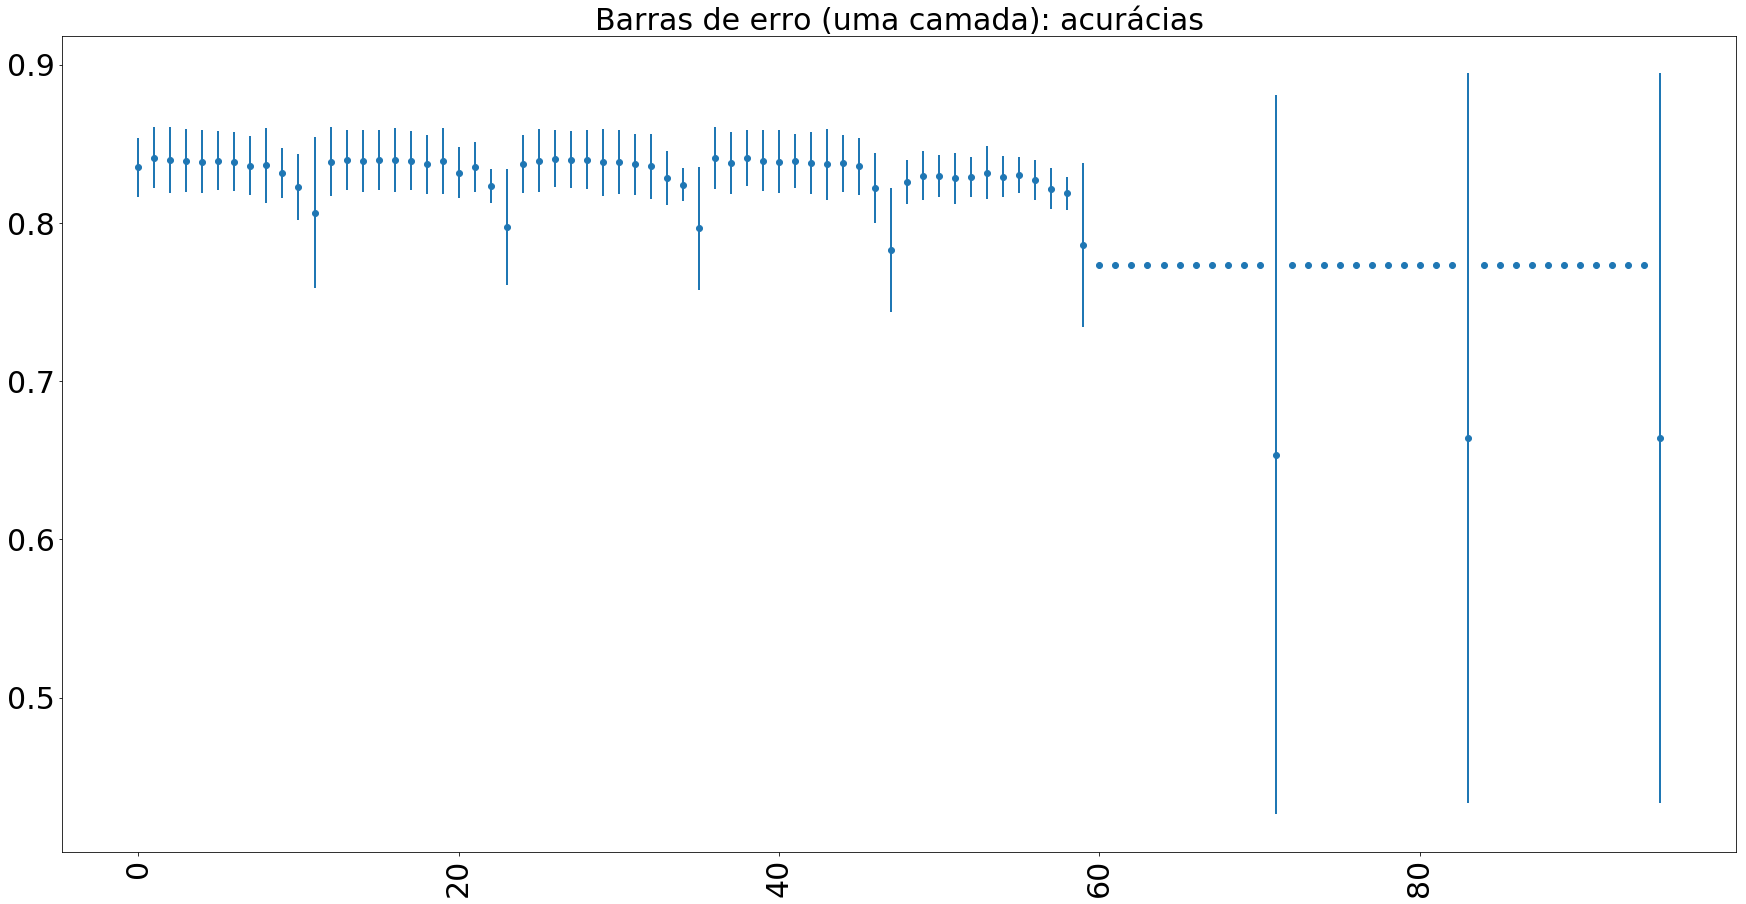

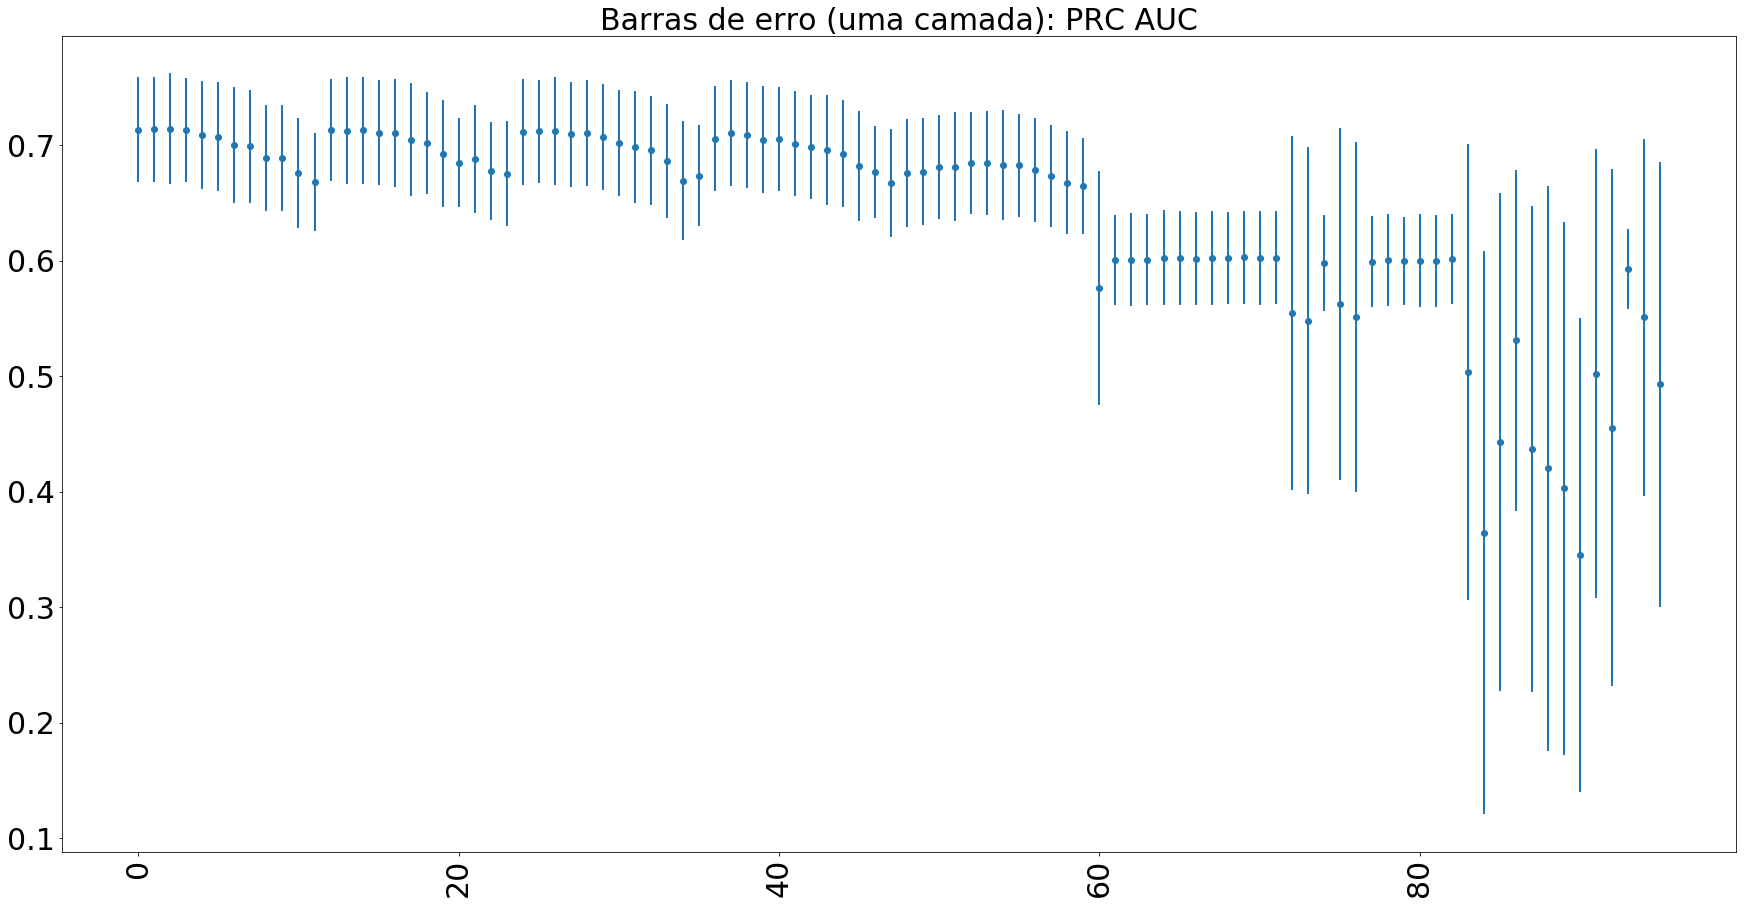

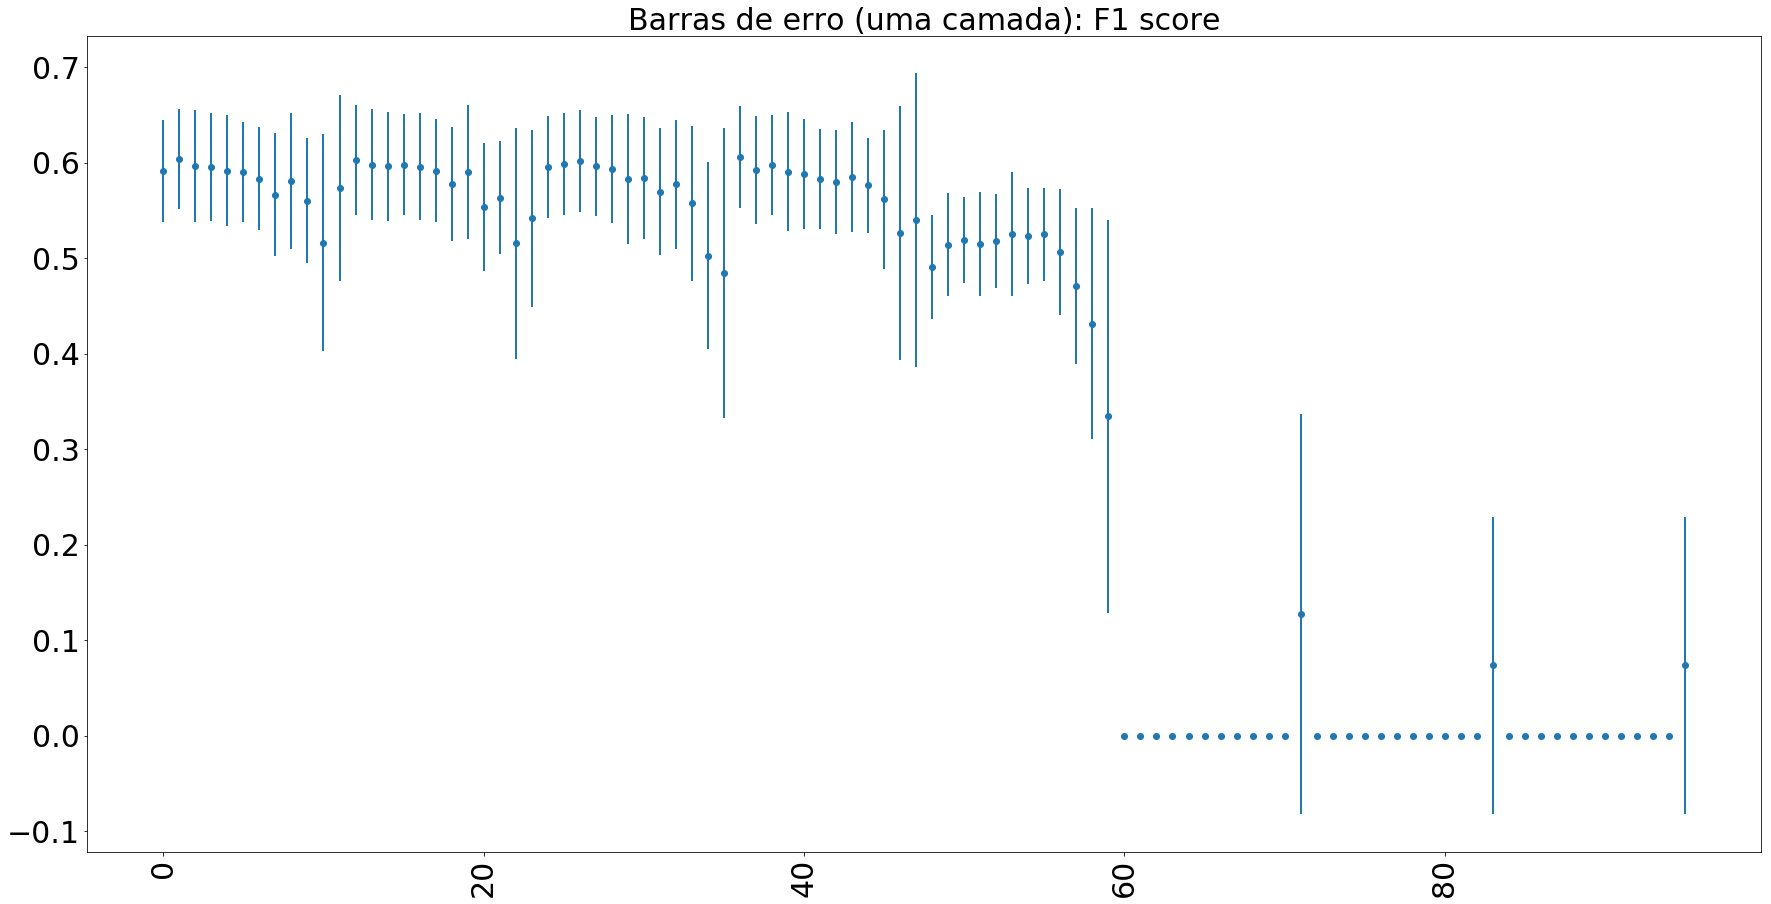

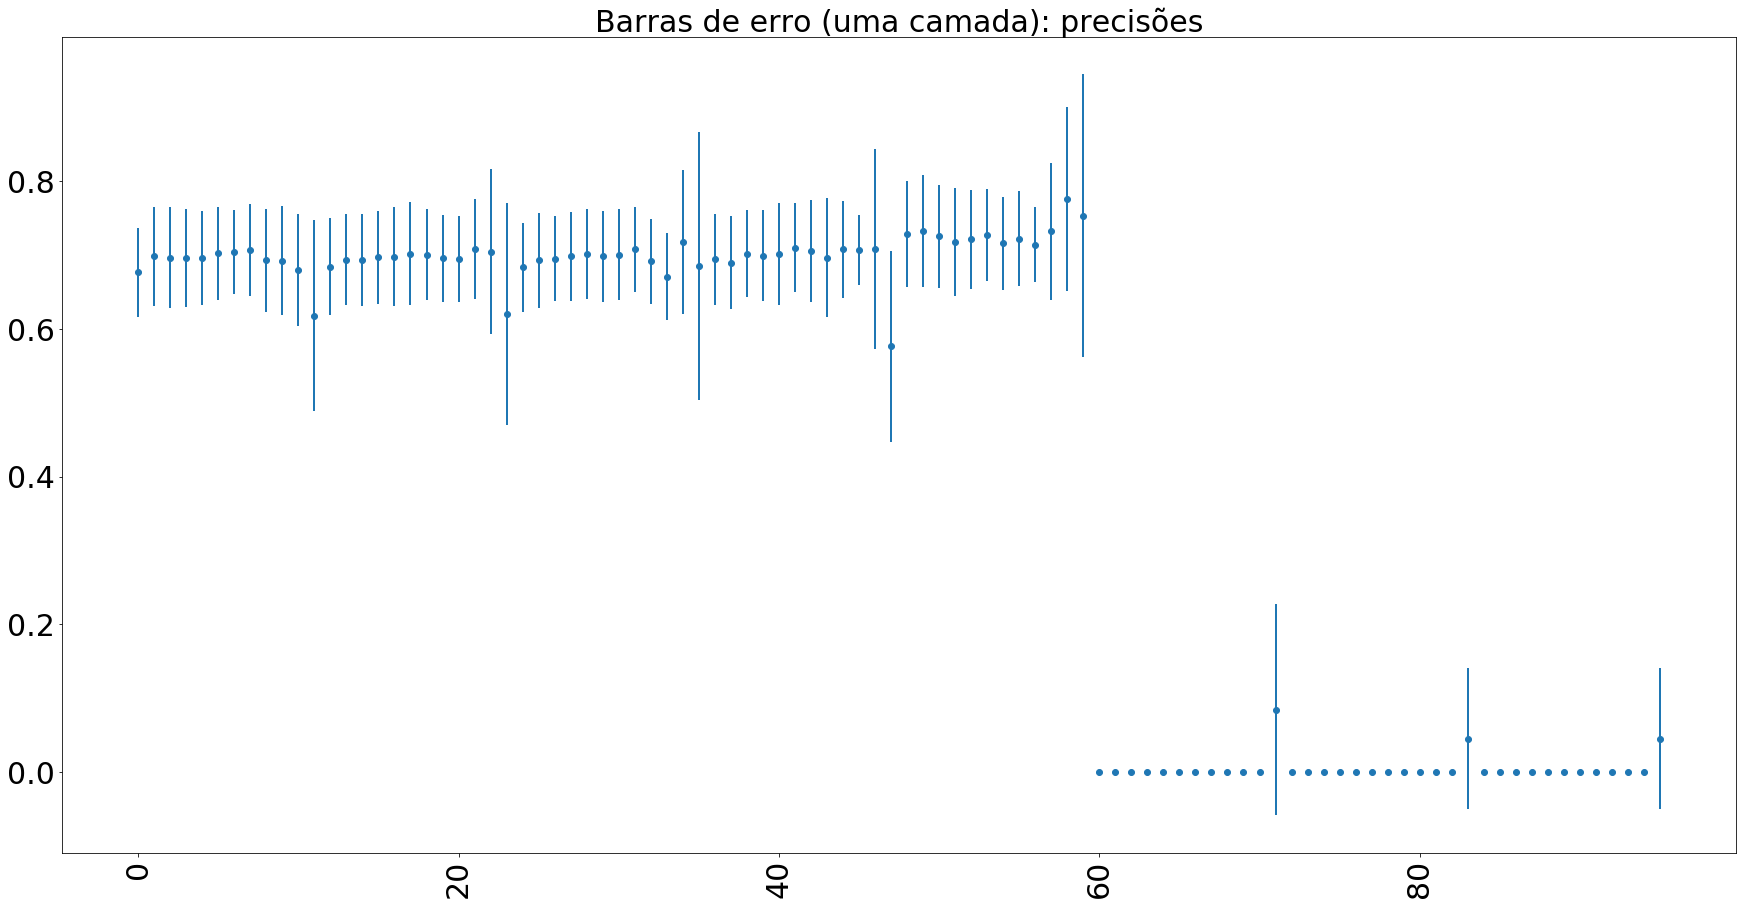

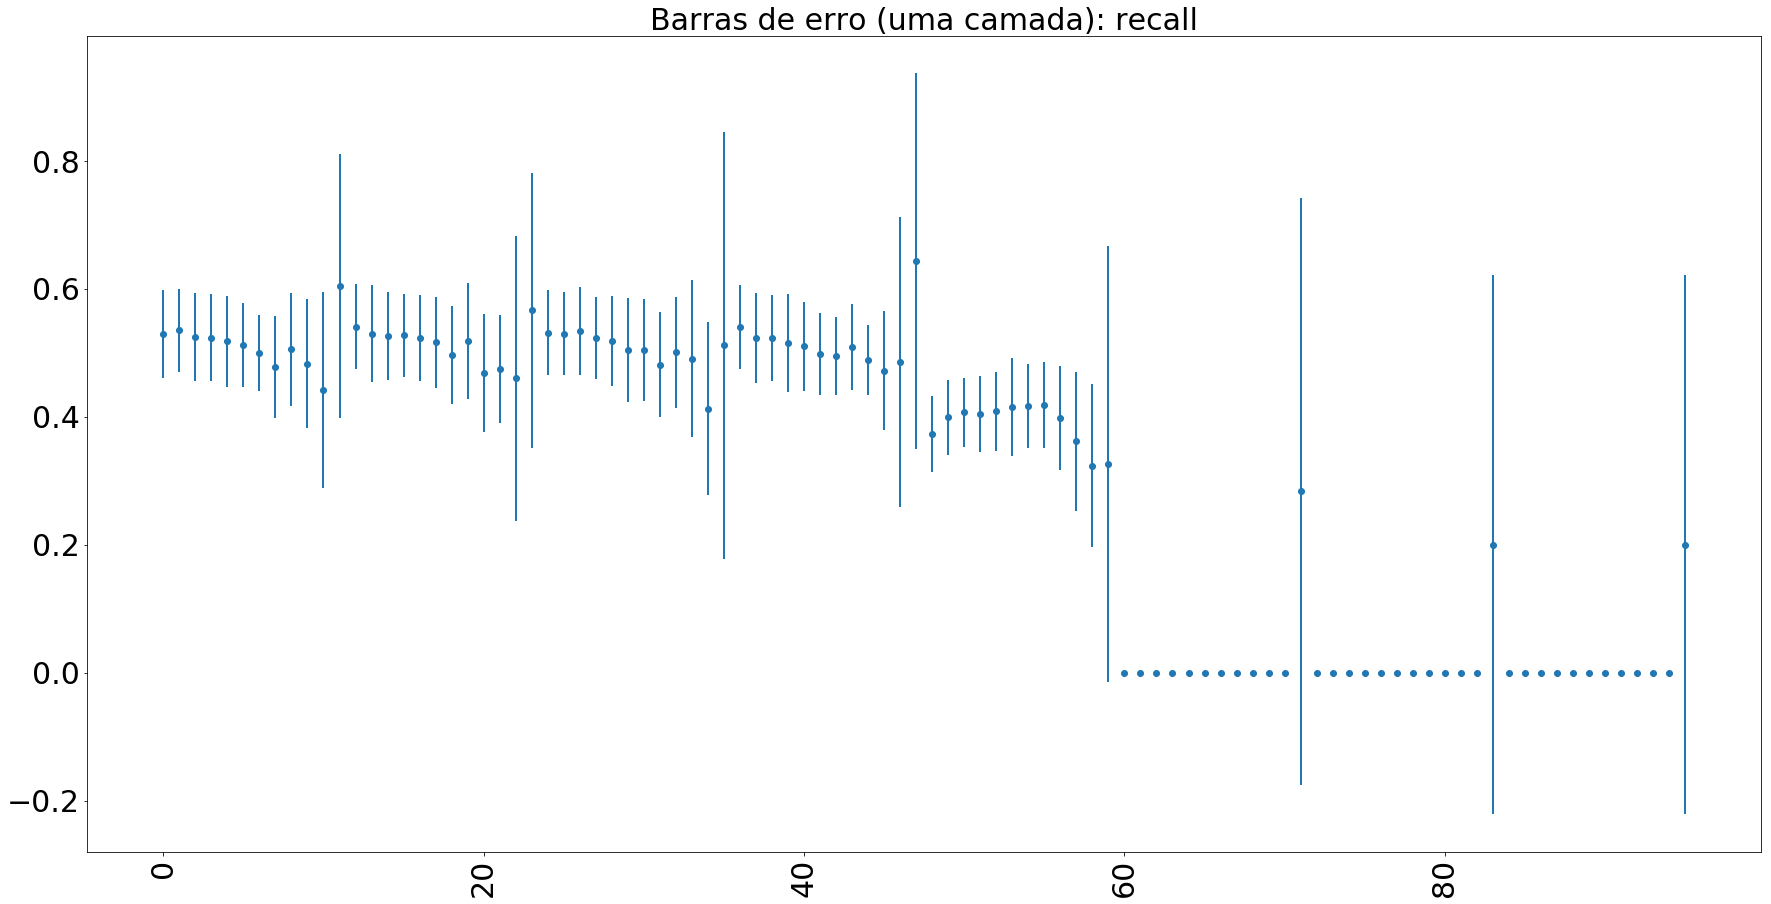

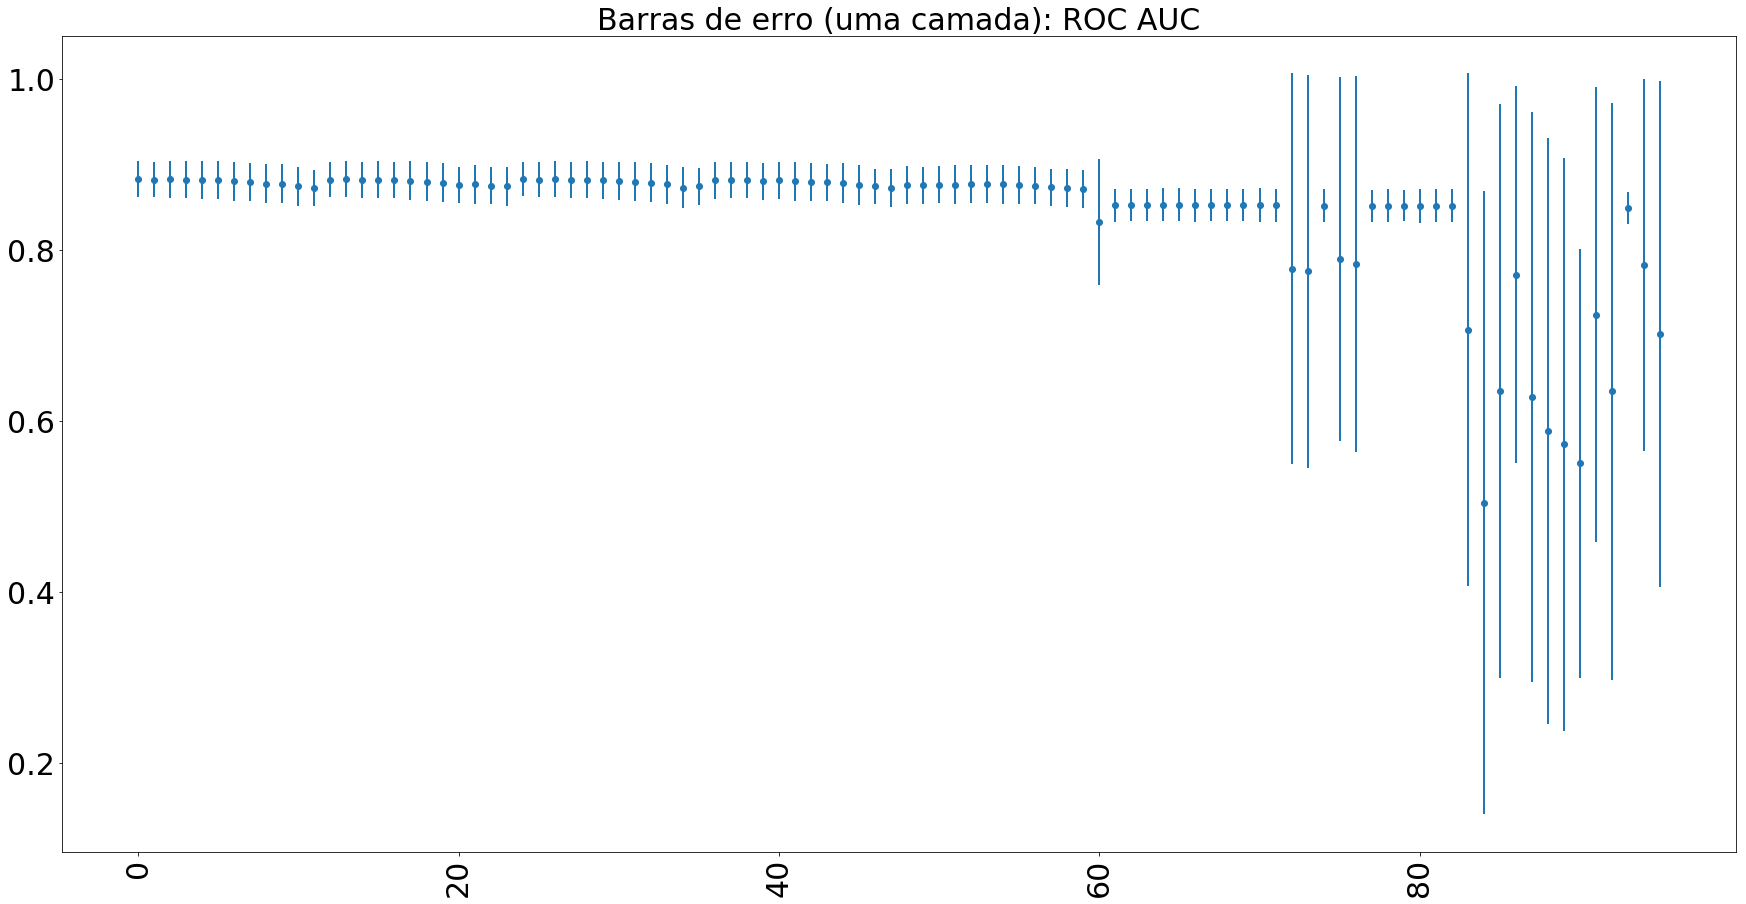

In [16]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'
str_balanceamento = 'desbalanceado'
fixed_param = 'param_alpha'
variable_param = 'param_hidden_layer_sizes'

path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=[fixed_param, variable_param], axis=0, inplace=True)
# results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

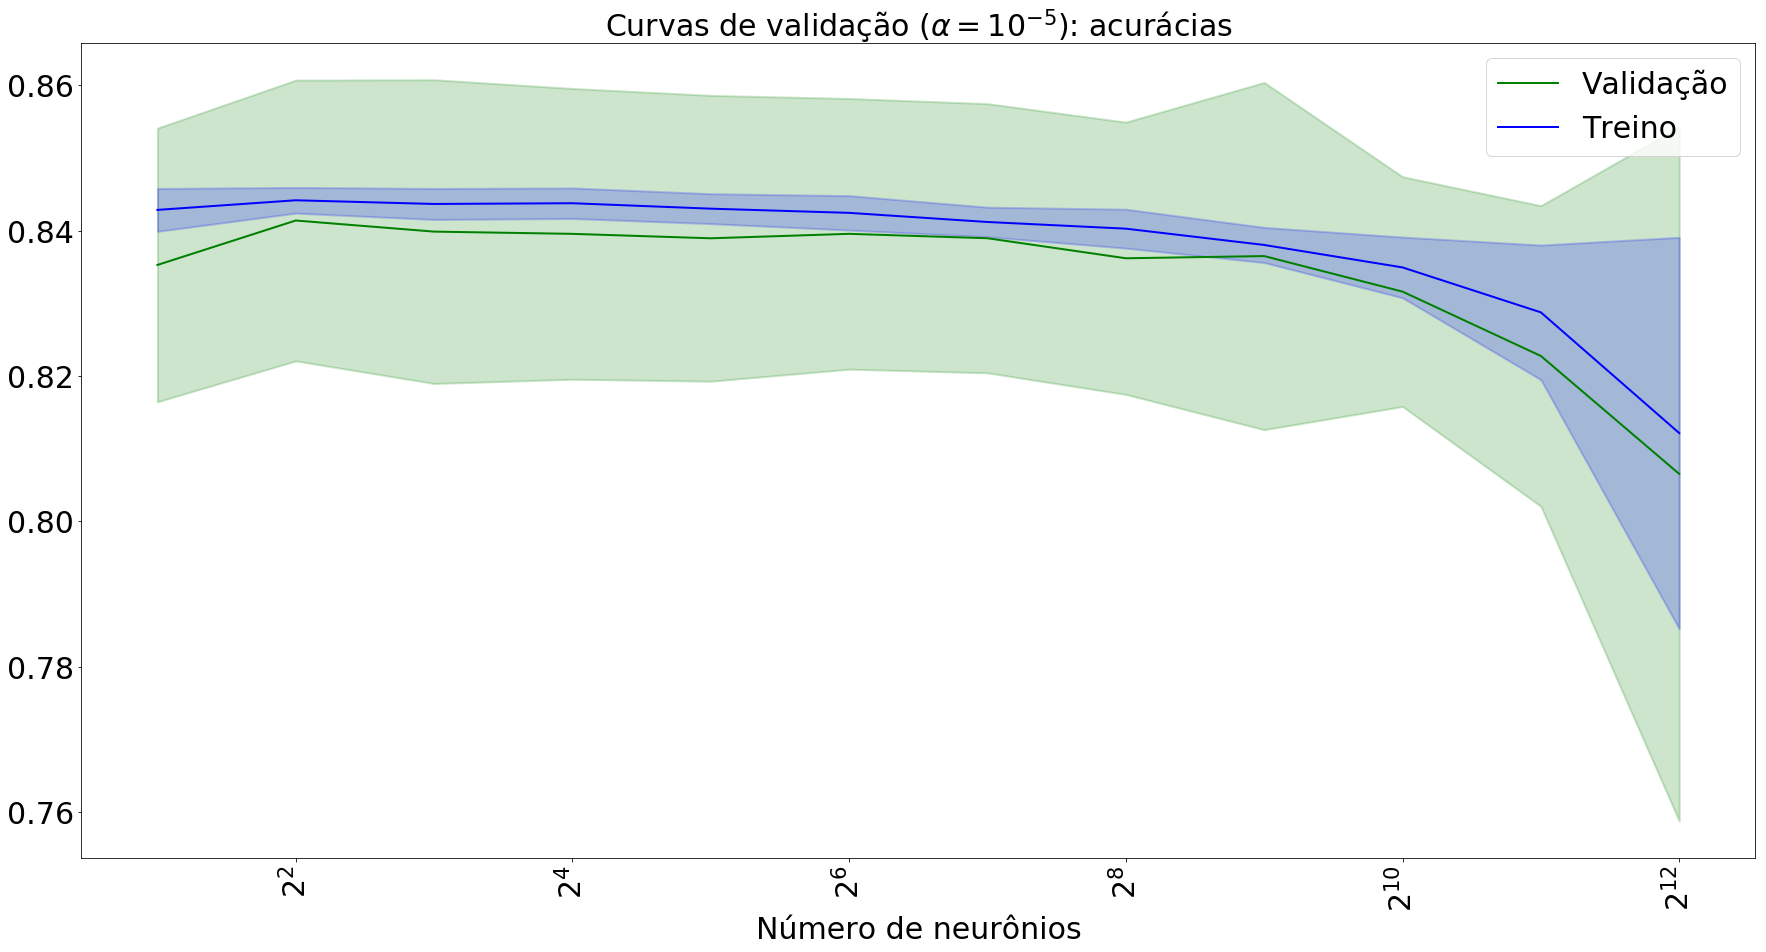

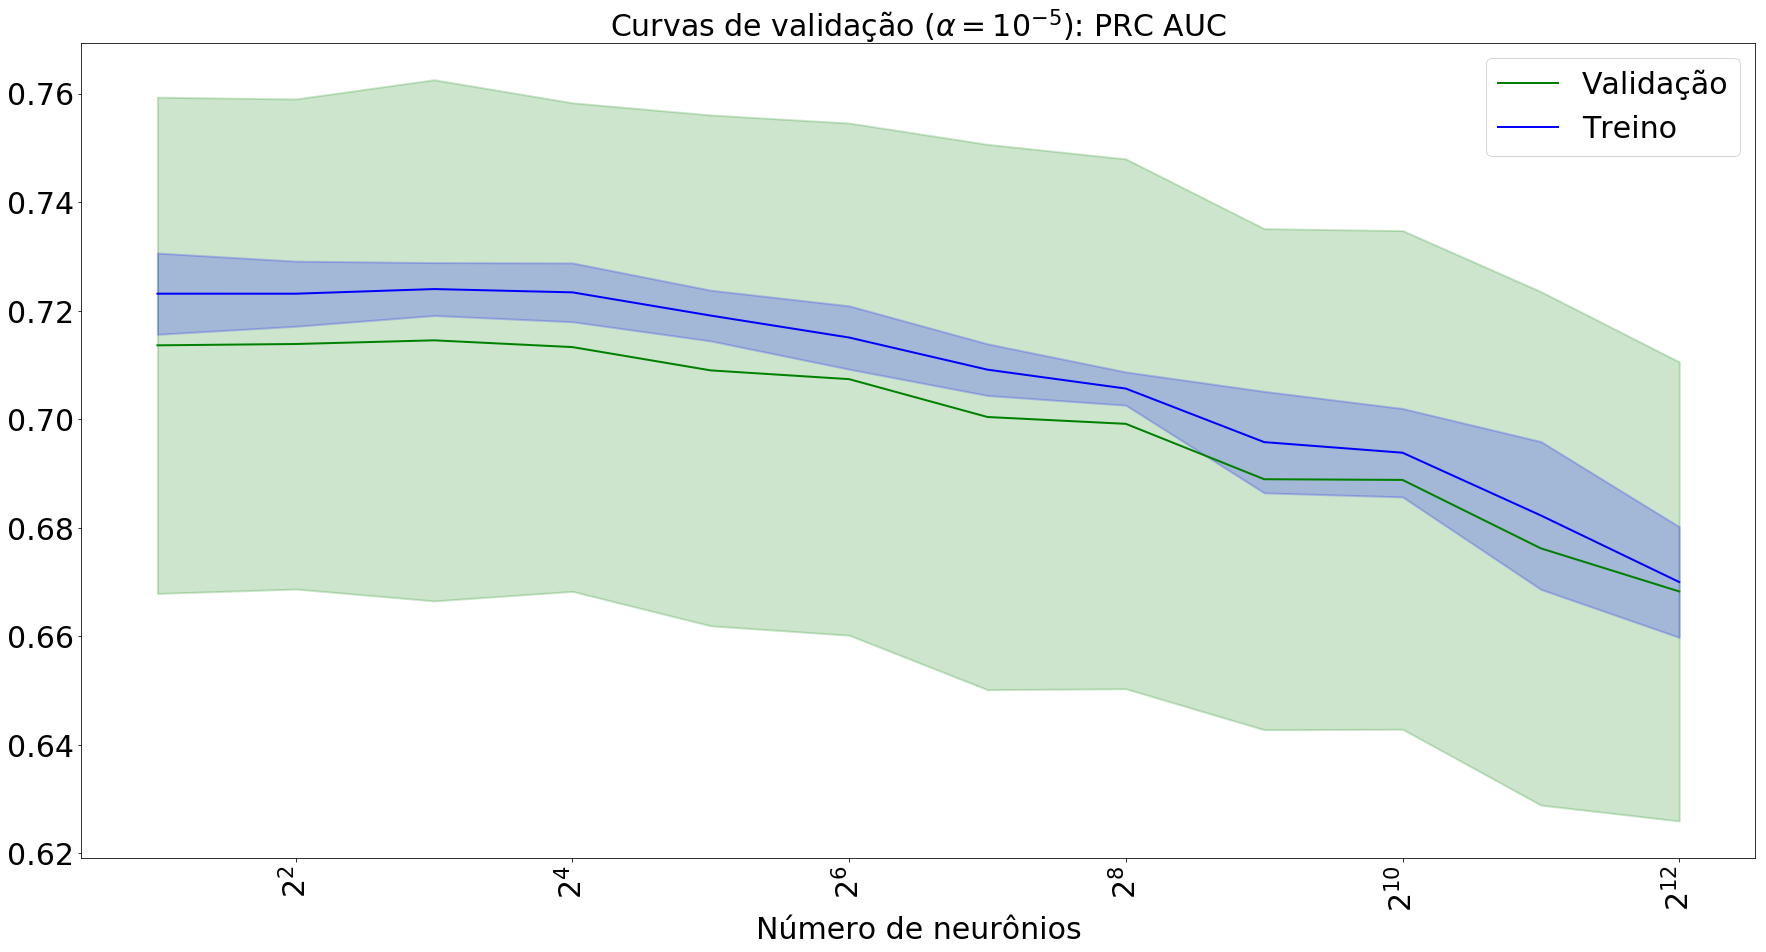

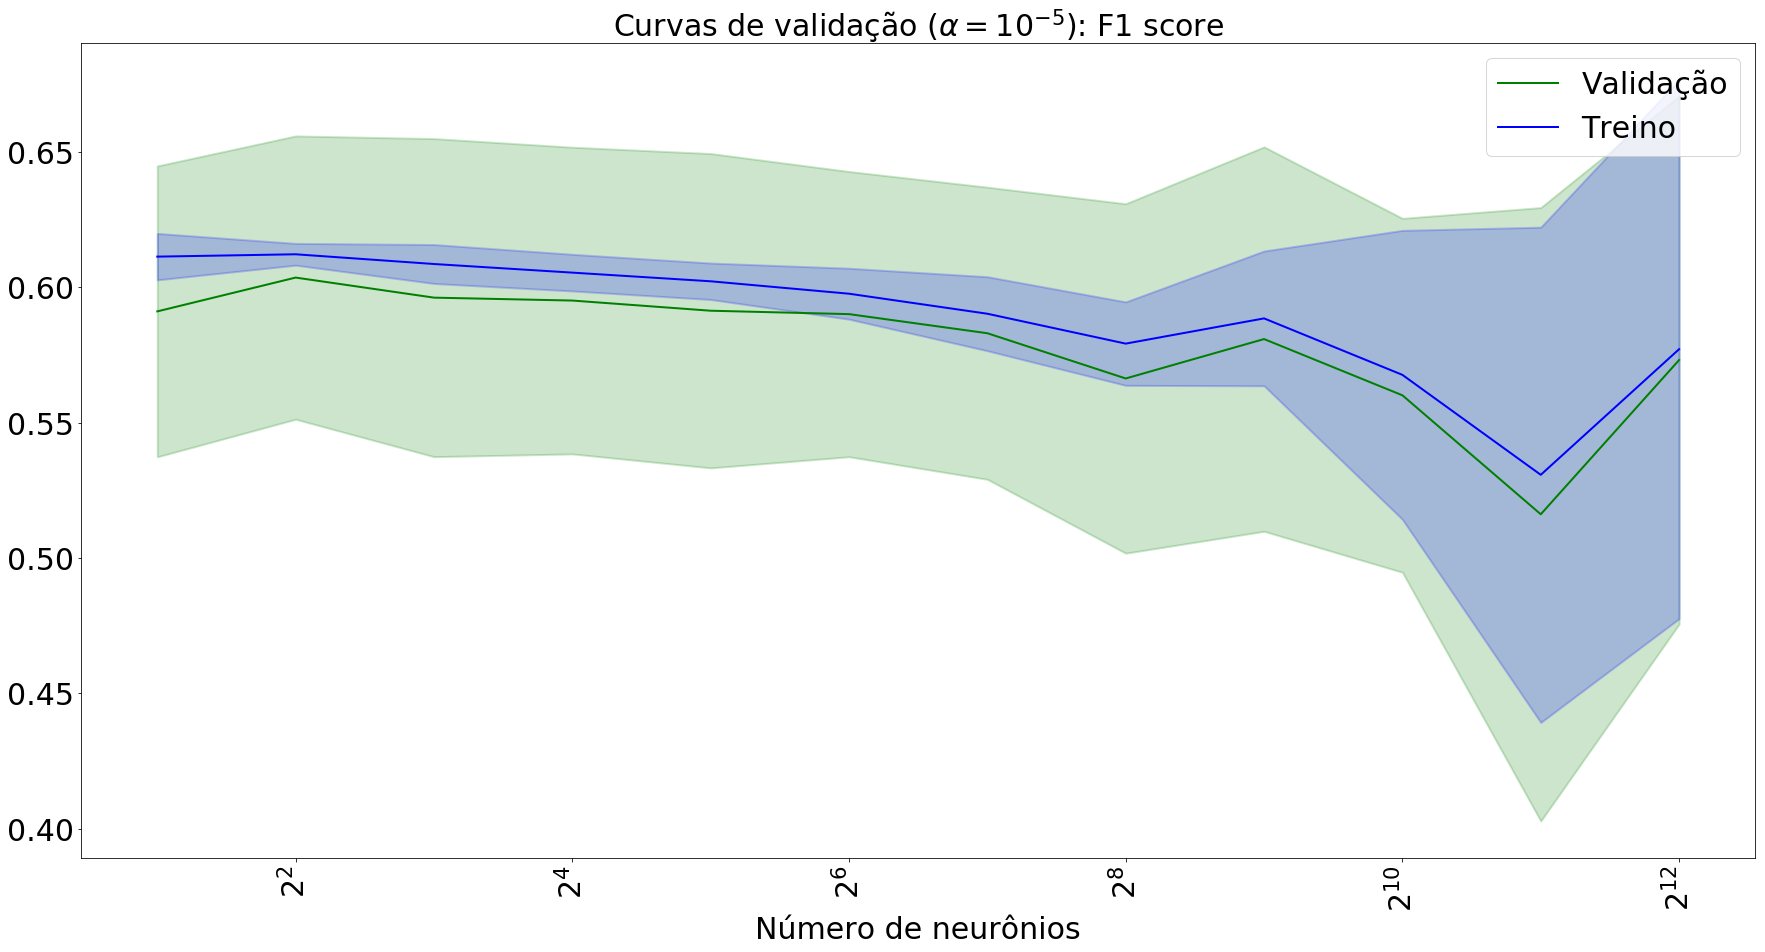

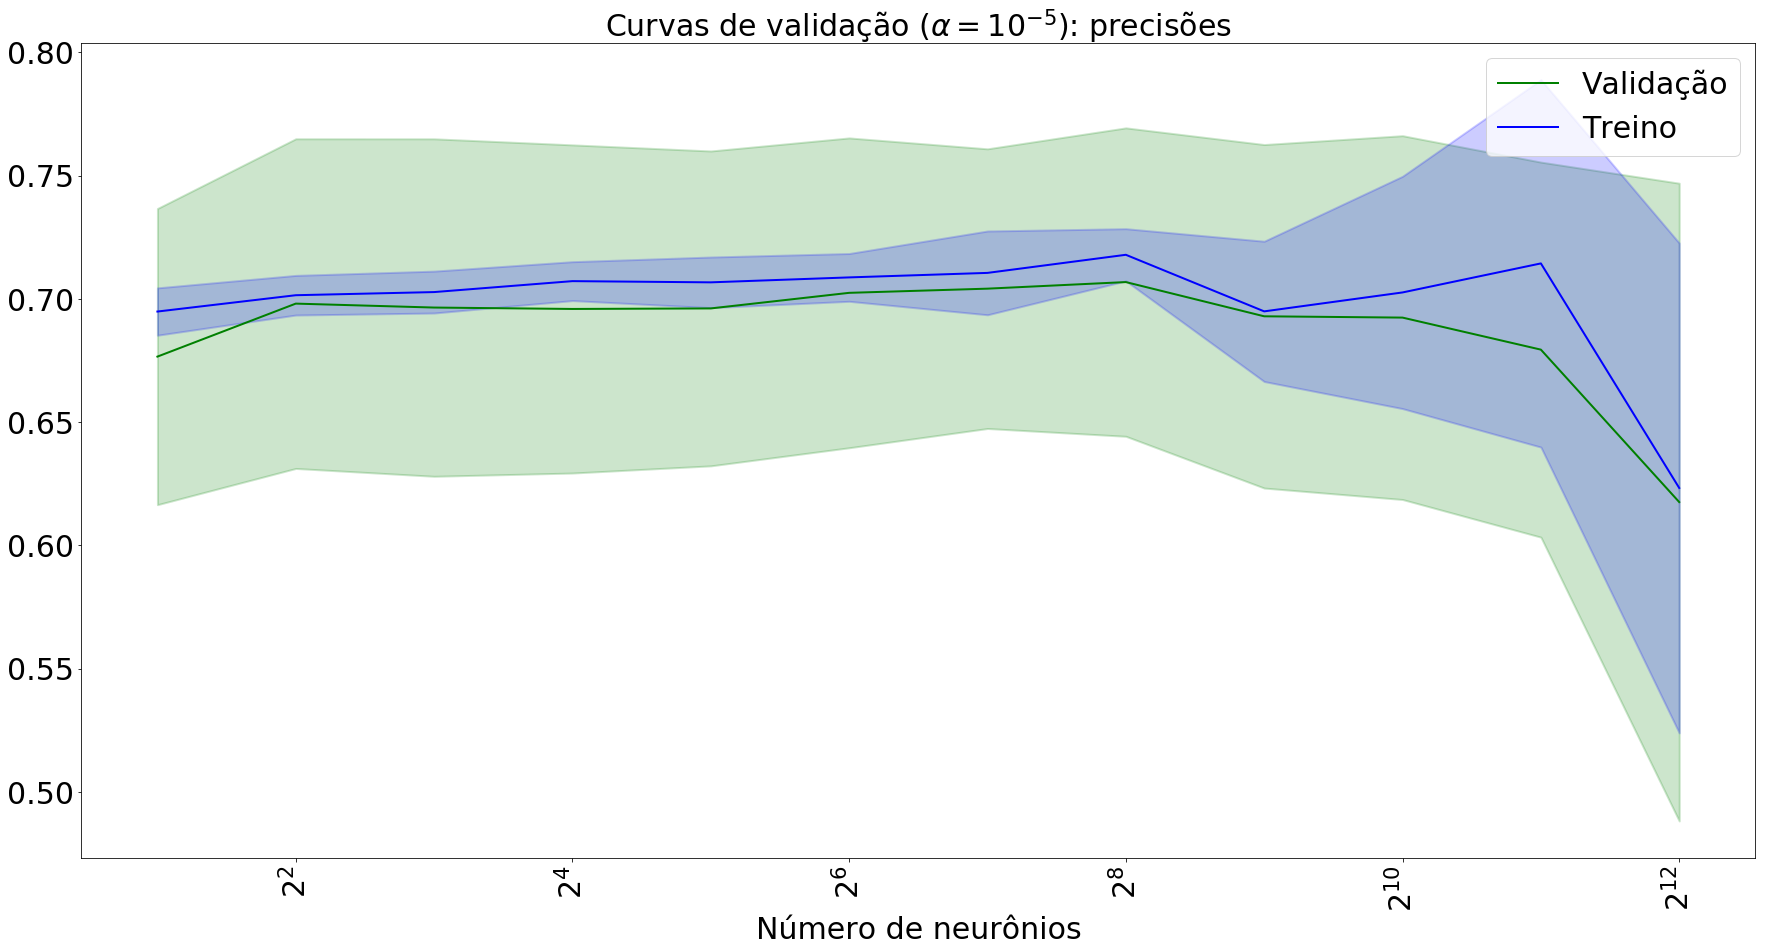

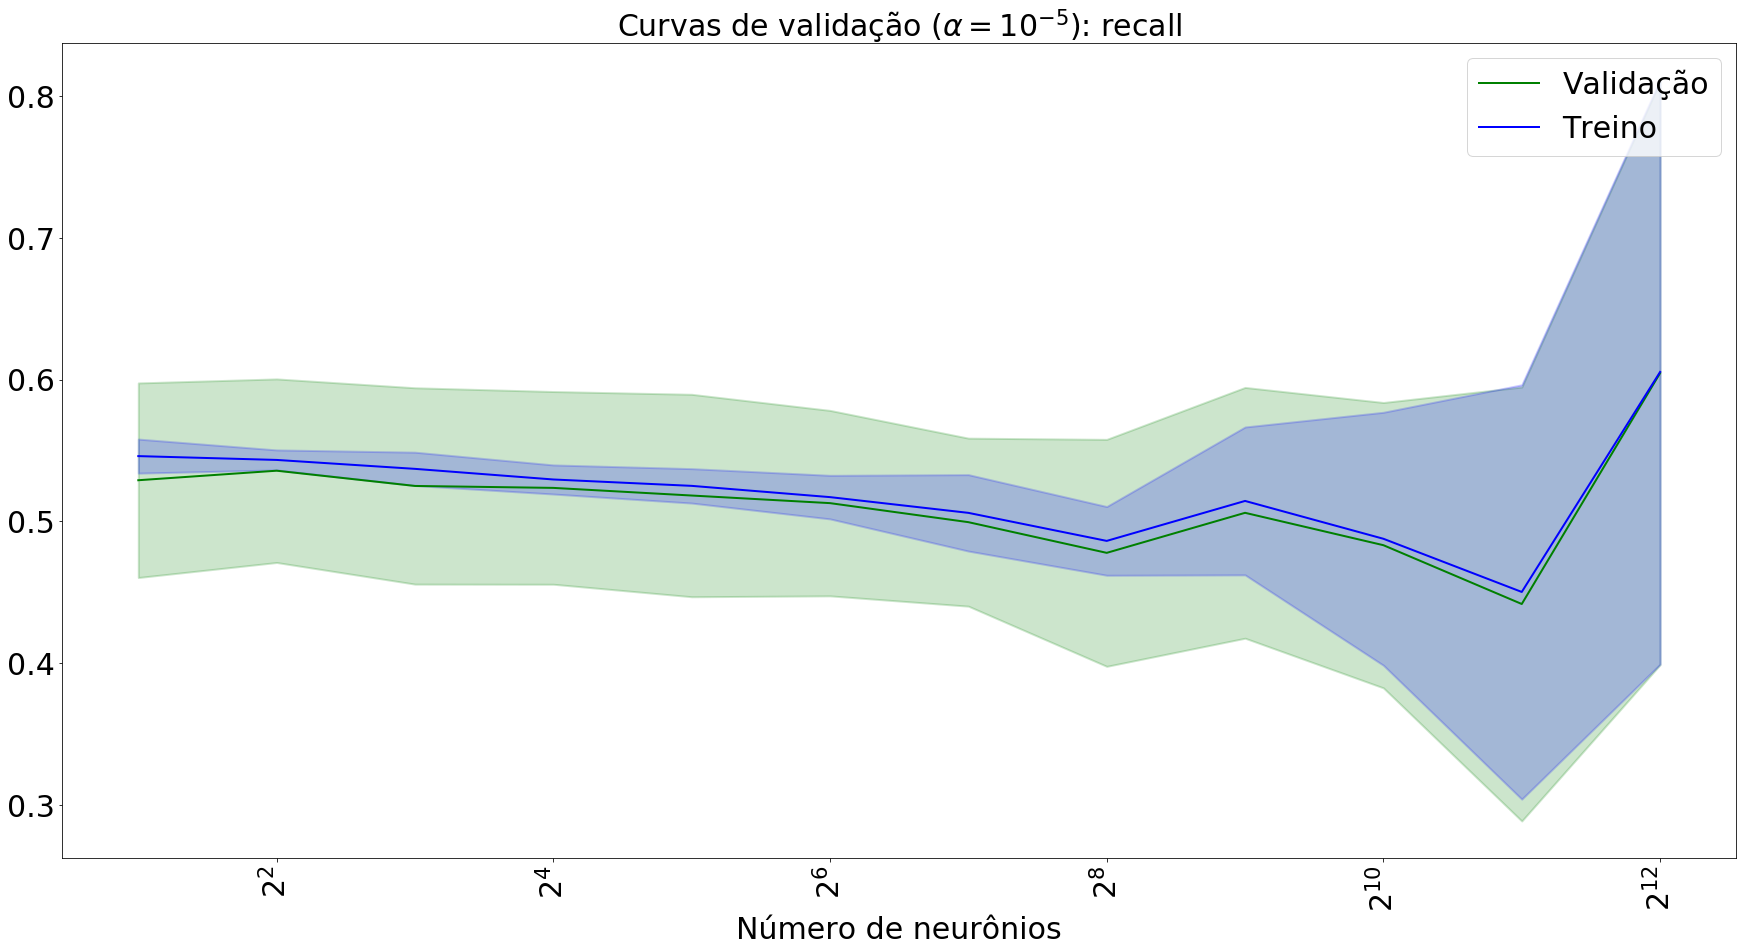

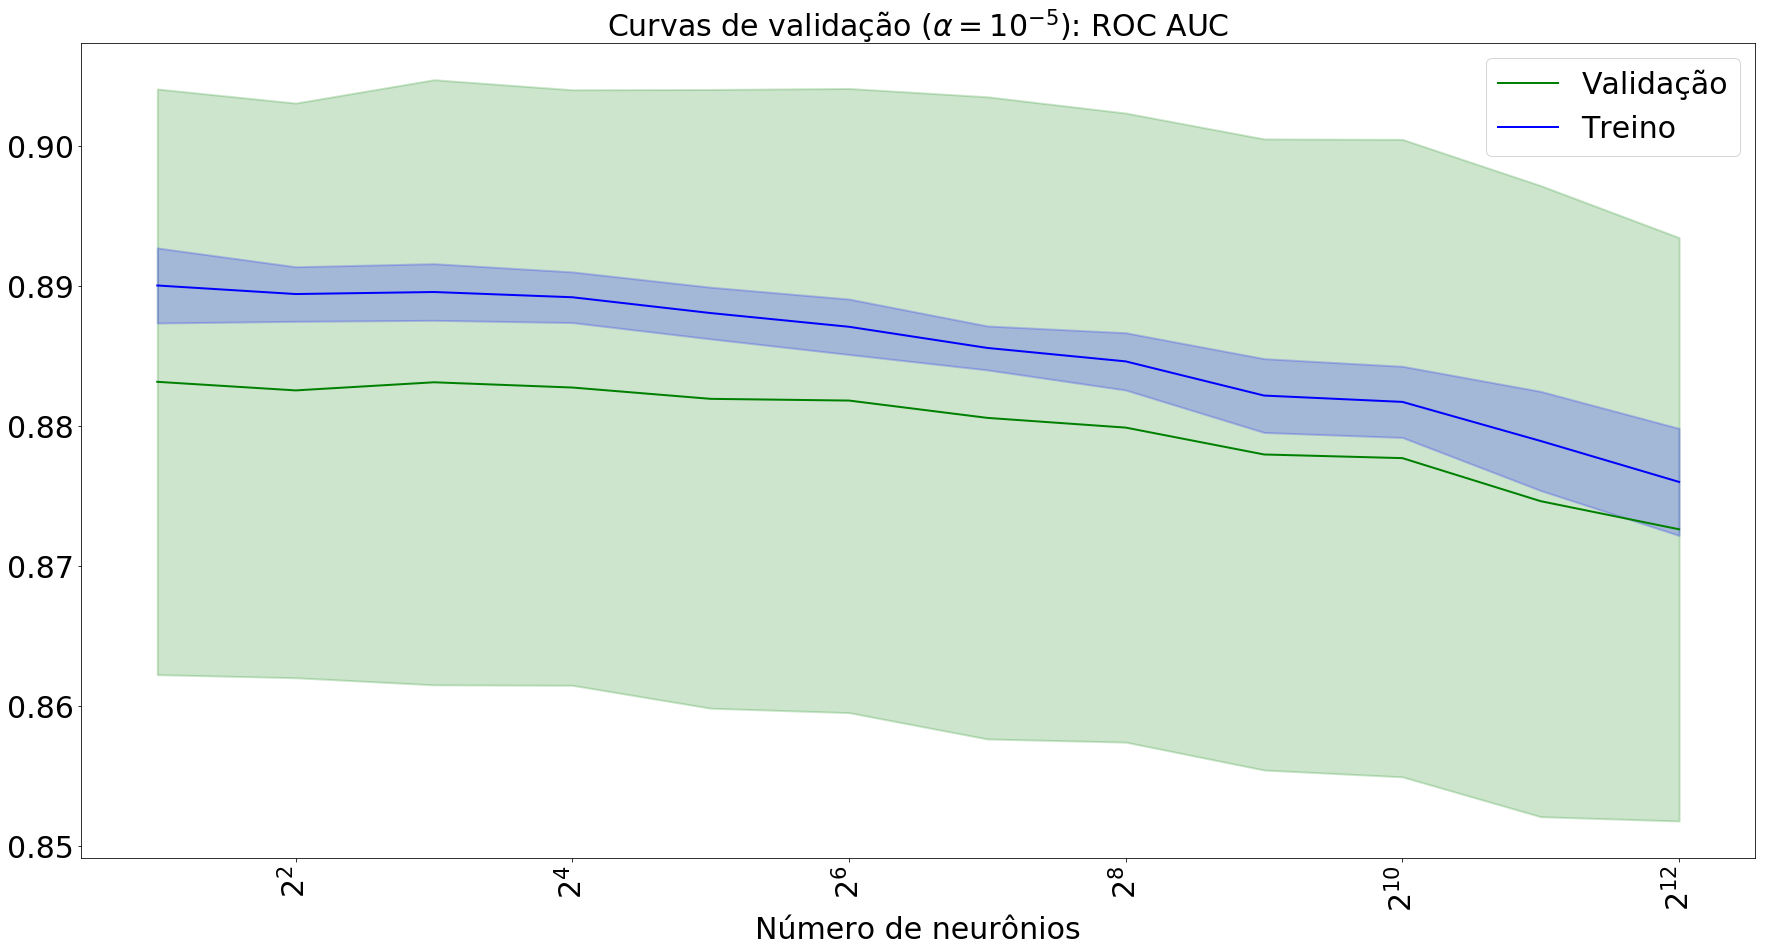

In [17]:
fixed_param_exp_values = [-5]

if fixed_param == 'param_alpha':
    
    fixed_param_exp_start_value = -5
    fixed_param_exp_end_value = 2
    fixed_param_base = 10
    fixed_param = 'alpha'
    
    variable_param = 'hidden_layer_sizes'
    variable_param_num_values = 12 
    variable_param_exp_start_value = 1
    variable_param_exp_end_value = 12
    variable_param_base = 2
    variable_param_values = np.logspace(start=variable_param_exp_start_value,stop=variable_param_exp_end_value,
                                        num=variable_param_num_values,base=variable_param_base)
    
    
elif fixed_param == 'param_hidden_layer_sizes':

    fixed_param_exp_start_value = 1
    fixed_param_exp_end_value = 12
    fixed_param_base = 2
    fixed_param = 'hidden_layer_sizes'
    
    variable_param = 'alpha'
    variable_param_num_values = 8 
    variable_param_exp_start_value = -5
    variable_param_exp_end_value = 2
    variable_param_base = 10
    variable_param_values = np.logspace(start=variable_param_exp_start_value,stop=variable_param_exp_end_value,
                                        num=variable_param_num_values,base=variable_param_base)
    
fixed_param_exp_dict = dict((y,x) for x,y in enumerate(list(range(fixed_param_exp_start_value,fixed_param_exp_end_value+1))))
# print(fixed_param_exp_dict)

for fixed_param_exp_val in fixed_param_exp_values:
    
    # Localiza na tabela as colunas com as medidas resultantes correspondentes ao valor parâmetro fixo 
    # e aos valores dos parâmetro variável
    
    range_cols = [fixed_param_exp_dict[fixed_param_exp_val]*variable_param_num_values+i 
                  for i in range(0,variable_param_num_values)]
    
    for metrica in lista_metricas:

        results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
        results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()
        
        results_test_filtered = results_test_filtered.iloc[:, range_cols]
        results_train_filtered = results_train_filtered.iloc[:, range_cols]

        fig = plt.figure(figsize=(30,15))
        plt.semilogx(variable_param_values, results_test_filtered.mean(), 
                     label='Validação', color='green', lw=2, basex=variable_param_base)
        
        plt.fill_between(variable_param_values, results_test_filtered.mean() - results_test_filtered.std(),
                     results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

        plt.semilogx(variable_param_values, results_train_filtered.mean(), 
                     label='Treino', color='blue', lw=2, basex=variable_param_base)
        
        plt.fill_between(variable_param_values, results_train_filtered.mean() - results_train_filtered.std(),
                     results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)
        
        if fixed_param == 'alpha':
            plot_title = 'Curvas de validação ($\\' + fixed_param + ' = ' + str(fixed_param_base) + '^{' + str(fixed_param_exp_val) + '}$): ' + metrica[1]
            plot_xlabel = 'Número de neurônios'
        elif fixed_param =='hidden_layer_sizes':
            plot_title = 'Curvas de validação ($' + fixed_param + ' = ' + str(fixed_param_base) + '^{' + str(fixed_param_exp_val) + '}$): ' + metrica[1]
            plot_xlabel = '$\alpha$'
        
        plt.title(plot_title, fontsize=30)
        plt.xticks(fontsize=30, rotation=90)
        plt.xlabel(plot_xlabel, fontsize=30)
        plt.yticks(fontsize=30)
        plt.legend(loc='best', fontsize=30)
        
#         filename_graficos = 'mlp-abordagem-2-'+str_balanceamento+'-curvas_validacao-'+variable_param+'-'+str(metrica[0])+'.png'
#         plt.savefig(path_graficos+filename_graficos)
        
        plt.show()

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [9]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 3: Imputar os valores faltantes e retirar outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

# clf_one.fit(pd.get_dummies(train_data_3), train_target_3) # Classes desbalanceadas
# joblib.dump(clf_one, 
#             path_arquivos+'mlp-one-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_one.fit(train_data_b_3, train_target_b_3) # Classes balanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_3), train_target_3)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_3, train_target_b_3)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

['Classificadores/Redes-neurais-MLP/mlp-one-abordagem-3-desbalanceado-dataset-10pct.pkl']

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [10]:
# Descomentar somente se for necessário retreinar o classificador

# Abordagem 4: Retirar os valores faltantes e retirar outliers

path_arquivos = 'Classificadores/Redes-neurais-MLP/' # Path para salvar os resultados dos classificadores

# clf_one.fit(pd.get_dummies(train_data_4), train_target_4) # Classes desbalanceadas
# joblib.dump(clf_one, 
#             path_arquivos+'mlp-one-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_one.fit(train_data_b_4, train_target_b_4) # Classes balanceadas
joblib.dump(clf_one, 
            path_arquivos+'mlp-one-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(pd.get_dummies(train_data_4), train_target_4)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

# clf_two.fit(train_data_b_4, train_target_b_4)
# joblib.dump(clf_two, 
#             path_arquivos+'mlp-two-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada


/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/neural

['Classificadores/Redes-neurais-MLP/mlp-one-abordagem-4-desbalanceado-dataset-10pct.pkl']

In [ ]:
path_arquivos = 'Classificadores/Redes-neurais-MLP/'

clf_one_desbalanceado = joblib.load(path_arquivos+'mlp-one-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_one_desbalanceado.cv_results_)
results.sort_values(by=['param_alpha', 'param_hidden_layer_sizes'], axis=0, inplace=True)

# results['param_hidden_layer_sizes'].head()

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro (uma camada): ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()